# Liverpoo Analytics Challenge EDA + Screwing Ard 

In [1]:
%matplotlib inline

In [2]:
import os
import sys

# Arithmetic
import numpy as np
import scipy as sp
import pandas as pd

In [3]:
# Plotting
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as path_effects

#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.spatial import Voronoi
from shapely.geometry import Polygon


In [180]:
import warnings
warnings.filterwarnings('ignore')

# Just to avoid verbose warnings from Pandas indf_shots function 

# C:\Users\Gerald Lim\Anaconda3\envs\mlpy\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
# A value is trying to be set on a copy of a slice from a DataFrame

# See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
# C:\Users\Gerald Lim\Anaconda3\envs\mlpy\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
# A value is trying to be set on a copy of a slice from a DataFrame

From: https://www.youtube.com/watch?v=CQr7qFw6LfY

Code used in this video is available here: Prepare an analytics-driven opposition analysis of how Liverpool score goals. 

https://github.com/Friends-of-Trackin...

### The challenge:

1, Use one or more of the tools we have learnt so far (pitch control, speed and acceleration, passing networks, pass maps etc.) to analyse the data.

2, Feel free to combine with other data available from other sources on Liverpool.

3, Produce an output (short report/video) that can be communicated either to a coach, a video analyst or players.

4, Write technical details in a separate appendix.

5, Post a link in comments below and/or to Twitter using #FoT if you would like to enter  the competition to come on Friends of Tracking and talk about your analysis.

## Introduction

Liverpool's shite. This notebook will analyse goals scored by Liverpool from the provided datasets along with some extra by eye, followed by the exploration of several ideas of how the bin dippers generate recurring patterns of play in order to create their goal scoring opportunities. 

## The Raw Picture

### Who scores and assists the goals for the bin dippers? 

Source: Transfermarkt <br>

For all competitions
#### Season: 19/20 (as of 4/5/2020)
Goals
1. Salah: 20
2. Mane: 18
3. Firmino: 11
4. Oxlade-Chamberlain: 7
5. Origi: 5

Assists
1. Alexander-Arnold: 14
2. Firmino: 12
3. Mane: 12
4. Salah: 9
5. Robertson: 7

**Total goals scored:** 93 <br>
**% scored by forwards:** 55/93 = 59.1% <br>
**Total assists given:** 82 <br>
**% assisted by forwards:** 37/82 = 45% <br>
**% assisted by full-backs:** 24/82 = 29.2%

#### Season: 18/19 
1. Salah: 27
2. Mane: 26
3. Firmino: 16
4. Origi: 7
5. Milner: 7

Assists
1. Alexander-Arnold: 16
2. Robertson: 13
3. Salah: 12
4. Firmino: 8
5. Milner: 7

**Total goals scored:** 112 <br>
**% scored by forwards:** 86/112 = 76.8% <br>
**Total assists given:** 84 <br>
**% assisted by forwards:** 33/84 = 39.2% <br>
**% assisted by full-backs:** 29/84 = 34.5%

#### Some characteristics that can be inferred from the above

- Liverpool's goal scorers are very top-heavy and are more or less dominated by the 'big three' of Salah Mane and Firmino. The goals have been more well spread out this current season with the forwards accounting for "only" 59.1% of Liverpool's goals compared to 6.8% last season.

- Goal stats alone suggest Firmino plays more of a support striker role behind Mane and Salah, however this doesn't necessary mean that he bags more assists (see how he plays in the positional data). 

- Attacking full-backs. As we already expected, a big facet of Liverpool's game plan relies on their bombarding full-back duo, who have assisted on average over 30% of Liverpool's goals across the 2 seasons. 

- They've nearly matched their assist count from 18/19 with almost 20 fewer goals scored. This may hint that they are scoring a greater percentage of goals through deliberated crafted chances through team play as opposed to individual brilliance/ lucky bounces or deflections.  

- Only midfielders to feature in any of the G/A top 5 are borin' old James Milner (note however that 8 of his 11 goals from the last 2 seasons have come from penalties) and Alex Oxlade-Chamberlain who hasn't been much of a starter since returning from long term injury. Goals don't come too often from their midfield, although when they do...fml

## Data Exploration

Description from: https://github.com/Friends-of-Tracking-Data-FoTD/Last-Row

This repository was created to share new tracking data for educational (and recreational) purposes as part of the Friends of Tracking initiative.

The data was collected mainly to make the animations posted on twitter account @lastrowview, and it lacks the accuracy needed for research. Most notably, not all players are included in each play (although every player near the ball at any time is).

The main sample file is liverpool_2019.csv, which contains 19 goals scored by Livepool FC in 2019.

Columns included:

play: the scoreline after the goal. The team who scored the goal is the one next to the brackets. <br>
frame: the frame number for the current location. Data provided has 20 frames per second. <br>
player: the id of the player. The id is consistent within a play but not between plays. <br>
player_num: the player jersey number. This number is the official one, and did not change for Liverpool in 2019. You can check the corresponding names at this wikipedia link. <br>
x, y: coordinates for the player/ball. Pitch coordinates go from 0 to 100 on each axis. <br>
dx, dx: change in (x,y) coordinates from last frame to current frame <br>
z: height, from 0 to 1.5 (only filled for the ball) <br>
bgcolor: the main color for the team (used as background color) <br>
edgecolor the secondary color (used as edge color) <br>

Additionally, a pass dataset was created from liverpool_2019.csv in the demo notebook: liverpool_2019_passes.csv

Let's attempt a simple task which is plot the game frame (using the footyviz package) and the shot trajectory at the time which a goal is scored. 

In [185]:
# Load Data
data = pd.read_csv('../datasets/positional_data/liverpool_2019.csv', index_col=('play', 'frame'))

data.head()

Unnamed: 0 bgcolor        dx        dy  \
play                          frame                                           
Liverpool [3] - 0 Bournemouth 0               0     NaN  0.000000  0.000000   
                              1               1     NaN  0.185745  1.217580   
                              2               2     NaN  0.178659  1.171133   
                              3               3     NaN  0.171573  1.124685   
                              4               4     NaN  0.164488  1.078238   

                                    edgecolor  player  player_num team  \
play                          frame                                      
Liverpool [3] - 0 Bournemouth 0           NaN       0         NaN  NaN   
                              1           NaN       0         NaN  NaN   
                              2           NaN       0         NaN  NaN   
                              3           NaN       0         NaN  NaN   
                              4           NaN       0         NaN  NaN   

                                             x          y    z  
play                          frame                             
Liverpool [3] - 0 Bournemouth 0      46.394558  11.134454  0.0  
                              1      46.580302  12.352034  0.0  
                              2      46.758961  13.523166  0.0  
                              3      46.930535  14.647852  0.0  
                              4      47.095022  15.726090  0.0

In [186]:
#list of goals included in the dataset
data.index.get_level_values('play').unique()

Index(['Liverpool [3] - 0 Bournemouth', 'Bayern 0 - [1] Liverpool',
       'Fulham 0 - [1] Liverpool', 'Southampton 1 - [2] Liverpool',
       'Liverpool [2] - 0 Porto', 'Porto 0 - [2] Liverpool',
       'Liverpool [4] - 0 Barcelona', 'Liverpool [1] - 0 Wolves',
       'Liverpool [3] - 0 Norwich', 'Liverpool [2] - 1 Chelsea',
       'Liverpool [2] - 1 Newcastle', 'Liverpool [2] - 0 Salzburg',
       'Genk 0 - [3] Liverpool', 'Liverpool [2] - 0 Man City',
       'Liverpool [1] - 0 Everton', 'Liverpool [2] - 0 Everton',
       'Bournemouth 0 - 3 Liverpool', 'Liverpool [1] - 0 Watford',
       'Leicester 0 - [3] Liverpool'],
      dtype='object', name='play')

In [308]:
#select a goal that I'm familiar with 
play = 'Southampton 1 - [2] Liverpool' 

# https://www.youtube.com/watch?v=TQjqT17gO9A (highlights)

df = data.loc[play]
df.reset_index()

,frame,Unnamed: 0,bgcolor,dx,dy,edgecolor,player,player_num,team,x,y,z
0,0,0,NaN,-0.010178,-0.334472,NaN,0,NaN,NaN,85.831499,45.736140,0.0
1,1,1,NaN,-0.011633,-0.311695,NaN,0,NaN,NaN,85.819866,45.424444,0.0
2,2,2,NaN,-0.013031,-0.289628,NaN,0,NaN,NaN,85.806835,45.134816,0.0
3,3,3,NaN,-0.014370,-0.268271,NaN,0,NaN,NaN,85.792465,44.866544,0.0
4,4,4,NaN,-0.015652,-0.247624,NaN,0,NaN,NaN,85.776813,44.618920,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4621,252,4621,red,0.064249,0.160786,black,52137,NaN,defense,4.777685,50.574231,0.0
4622,253,4622,red,0.066454,0.166302,black,52137,NaN,defense,4.844139,50.740534,0.0
4623,254,4623,red,0.068690,0.171899,black,52137,NaN,defense,4.912829,50.912433,0.0
4624,255,4624,red,0.000000,0.000000,black,52137,NaN,defense,4.912829,50.912433,0.0


Text(63.324135156485866, 52.43206452154886, '')

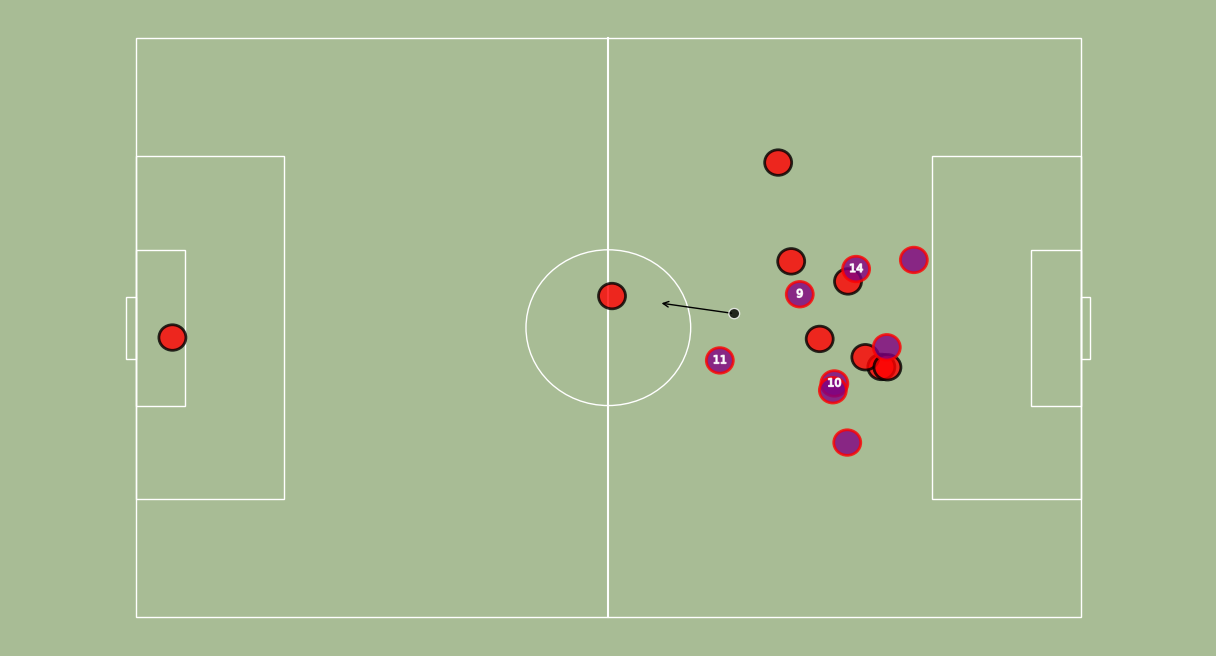

In [309]:
### import sys, os
sys.path.insert(0, os.path.abspath('../scripts/'))
import footyviz
from matplotlib import pyplot as plt

# Approximately when the shot is taken
fig, ax, dfFrame = footyviz.draw_frame(df, 96/20)

# Using final frame 124 for end ball location 
plt.annotate('', df.iloc[124][['x','y']], df.iloc[96][['x','y']] , arrowprops={'arrowstyle':'->'}, annotation_clip=False)

## Analysing the goals (shots)

Given that we only have a raw positional dataframe, we need to create our own "shots from which the goal was scored" dataframe. Luckily we already have a function that returns all frames which involve a ball possession from the starter notebook. This will allow us to easily identify the frame where the shot is taken as the last frame of ball possession. 

In [310]:
# Copied form defining possession notebook

def get_possession_df(df):
    #get a DataFrame for Ball position
    dfBall = df.reset_index()[df.reset_index().player==0].set_index('frame')[['x', 'y']]

    #temporary DataFrame with all player's position relative to the ball 
    dfTemp = df.reset_index().set_index('frame').join(dfBall, rsuffix='_ball')
    dfTemp = dfTemp[dfTemp.player!=0]
    dfTemp['dif_x'] = dfTemp['x'].sub(dfTemp['x_ball'])
    dfTemp['dif_y'] = (dfTemp['y'] - dfTemp['y_ball'])

    #DataFrame with all the frames where a player touches or has close control of the ball.
    dfPossession = dfTemp[((dfTemp[['dif_x', 'dif_y']]==0).sum(axis=1))==2].reset_index()
    dfPossession.player_num = dfPossession.player_num.astype('Int64')
    return dfPossession



Let's test this on a known scenario where a dribble preceded the shot taken (Mane 1-0 vs Bayern) 

In [312]:
dfPossession = get_possession_df(df)

dfPossession

,frame,Unnamed: 0,bgcolor,dx,dy,edgecolor,player,player_num,team,x,y,z,x_ball,y_ball,dif_x,dif_y
0,0,771,red,-0.010178,-0.334472,black,1778,<NA>,defense,85.831499,45.736140,0.0,85.831499,45.736140,0.0,0.0
1,1,772,red,-0.011633,-0.311695,black,1778,<NA>,defense,85.819866,45.424444,0.0,85.819866,45.424444,0.0,0.0
2,2,773,red,-0.013031,-0.289628,black,1778,<NA>,defense,85.806835,45.134816,0.0,85.806835,45.134816,0.0,0.0
3,3,774,red,-0.014370,-0.268271,black,1778,<NA>,defense,85.792465,44.866544,0.0,85.792465,44.866544,0.0,0.0
4,4,775,red,-0.015652,-0.247624,black,1778,<NA>,defense,85.776813,44.618920,0.0,85.776813,44.618920,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,228,485,purple,-0.241562,-0.108103,red,15,11,attack,16.842396,47.232156,0.0,16.842396,47.232156,0.0,0.0
144,229,486,purple,-0.235351,-0.105989,red,15,11,attack,16.607045,47.126167,0.0,16.607045,47.126167,0.0,0.0
145,230,487,purple,-0.229035,-0.103804,red,15,11,attack,16.378010,47.022362,0.0,16.378010,47.022362,0.0,0.0
146,231,488,purple,-0.222612,-0.101548,red,15,11,attack,16.155398,46.920814,0.0,16.155398,46.920814,0.0,0.0


Frame 130 is the last frame in which the ball is possessed by any player and hence the shot position.

Text(79.61932398691222, 60.777576754608056, '')

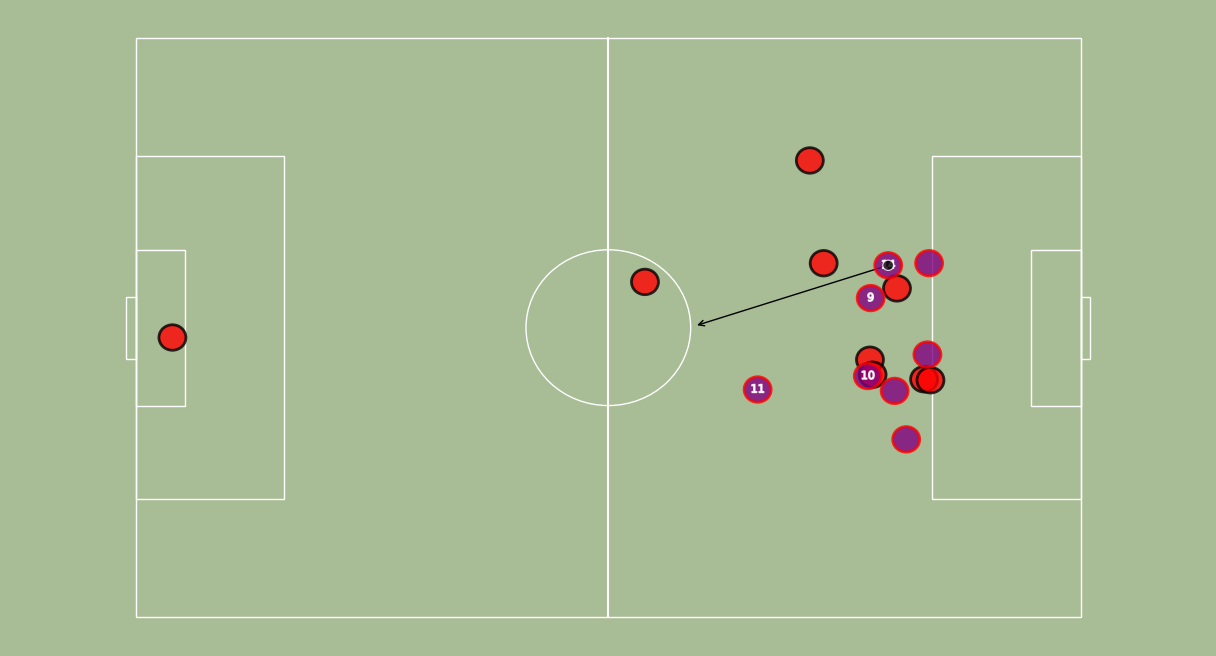

In [316]:
# Approximately when the shot is taken
fig, ax, dfFrame = footyviz.draw_frame(df, 72/20)

# Using final frame 124 for end ball location 
plt.annotate('', df.iloc[110][['x','y']], df.iloc[72][['x','y']] , arrowprops={'arrowstyle':'->'}, annotation_clip=False)

Looks legitimate enough! Now compile a dataframe of all the shot locations for the goals.

### Defining Passes (From starter notebook, credit FoT)

In [313]:
def get_passes_df(dfPossession):
    #determining the start end enf of each possession block
    poss_start = dfPossession[dfPossession['player']!=dfPossession.shift(1)['player']]
    poss_end = dfPossession[dfPossession['player']!=dfPossession.shift(-1)['player']]

    #relevant columns to keep in the final DataFrame
    columns = ['team', 'x', 'y', 'frame', 'player', 'player_num']
    
    #list of all changes in possession
    dfPasses = pd.concat([poss_end.reset_index()[columns].rename(lambda x: 'from_{}'.format(x), axis='columns'),
                          poss_start.iloc[1:].reset_index()[columns].rename(lambda x: 'to_{}'.format(x), axis='columns')
                         ], axis='columns')

    #keep all changes in possession from players of the same team
    dfPasses = dfPasses[dfPasses['from_team']==dfPasses['to_team']]
    return dfPasses

In [314]:
get_passes_df(dfPossession)

,from_team,from_x,from_y,from_frame,from_player,from_player_num,to_team,to_x,to_y,to_frame,to_player,to_player_num
0,defense,85.342088,42.882899,22,1778,<NA>,defense,78.387274,41.050413,48.0,23197.0,<NA>
2,attack,79.619324,60.777577,72,5047,14,attack,59.108295,50.272940,110.0,15.0,11


### Defining Shots

In [183]:
def get_shots(plays, invert=True):
    shots = pd.DataFrame()
    for play in plays:
        
        df = data.loc[play]
        dfPossession = get_possession_df(df)
        
        shot_frame = dfPossession.iloc[-1]
        
        # We might as well also get the end shot location which is simply the last frame of the movement.
        
        # Number of frames in the play
        frames = len(set(df.index))
        # Last frame of the ball
        end_frame = df.iloc[frames-1]
        x_e,y_e = end_frame.x, end_frame.y
        
        # New columns to the shots df row 
        shot_frame['x_end'] = x_e
        shot_frame['y_end'] = y_e
        
        shot_frame['frame_end'] = int(frames)-1
        
        # Need to invert all shots from one end so we only keep one side of the pitch. Let's keep the right half 
        
        if invert == True:
            if x_e < 50:
                shot_frame['x_end'] = 100.680272 #Defaults to this boundary value for x 
                shot_frame['x_ball'] = 100 - shot_frame['x_ball']
                shot_frame['y_end'] = 100 - shot_frame['y_end']
                shot_frame['y_ball'] = 100 - shot_frame['y_ball']
        
        shots = shots.append(shot_frame)
        
    shots['Goal'] = plays
        
    return shots

In [187]:
goals = data.index.get_level_values('play').unique()

df_shots = get_shots(goals)

In [188]:
df_shots

,Unnamed: 0,bgcolor,dif_x,dif_y,dx,dy,edgecolor,frame,frame_end,player,player_num,team,x,x_ball,x_end,y,y_ball,y_end,z,Goal
37,442.0,red,0.0,0.0,0.158824,0.376619,white,132.0,154.0,331.0,11.0,attack,88.980532,88.980532,100.680272,39.541178,39.541178,54.831933,0.0,Liverpool [3] - 0 Bournemouth
4,295.0,lightgray,0.0,0.0,0.068278,0.201862,red,130.0,164.0,13.0,10.0,attack,87.053896,87.053896,100.680272,68.421886,68.421886,45.378151,0.0,Bayern 0 - [1] Liverpool
93,351.0,red,0.0,0.0,-0.053411,0.398039,white,168.0,182.0,15.0,10.0,attack,6.826108,93.173892,100.680272,44.926209,55.073791,51.680672,0.0,Fulham 0 - [1] Liverpool
147,489.0,purple,0.0,0.0,-0.216084,-0.099221,red,232.0,256.0,15.0,11.0,attack,15.939313,84.060687,100.680272,46.821593,53.178407,45.588235,0.0,Southampton 1 - [2] Liverpool
107,373.0,red,0.0,0.0,-0.198303,-0.131959,white,178.0,194.0,13.0,9.0,attack,2.735684,97.264316,100.680272,47.570775,52.429225,51.890756,0.0,Liverpool [2] - 0 Porto
137,491.0,red,0.0,0.0,-0.277738,0.078725,white,234.0,256.0,12.0,11.0,attack,13.047305,86.952695,100.680272,41.285190,58.714810,52.941176,0.0,Porto 0 - [2] Liverpool
2,259.0,red,0.0,0.0,0.093055,0.108874,white,120.0,138.0,13.0,27.0,attack,93.586115,93.586115,100.680272,43.282858,43.282858,52.941176,0.0,Liverpool [4] - 0 Barcelona
4,1078.0,red,0.0,0.0,0.157741,-0.070723,white,136.0,156.0,1776.0,10.0,attack,93.884971,93.884971,100.680272,51.325748,51.325748,46.008403,0.0,Liverpool [1] - 0 Wolves
54,414.0,red,0.0,0.0,-0.228701,0.310314,white,116.0,148.0,1168.0,27.0,attack,9.404133,90.595867,100.680272,46.619919,53.380081,53.361345,0.0,Liverpool [3] - 0 Norwich
73,357.0,red,0.0,0.0,0.209132,-0.217544,white,162.0,194.0,12.0,10.0,attack,89.108025,89.108025,100.680272,61.642652,61.642652,48.949580,0.0,Liverpool [2] - 1 Chelsea


#### Visualise the shots taken
Probably need to draw my own pitch for this. We'd also only want a half pitch for this and also a flipped view for this. 

In [370]:
X_SIZE = 105
Y_SIZE = 68

BOX_HEIGHT = (16.5*2 + 7.32)/Y_SIZE*100
BOX_WIDTH = 16.5/X_SIZE*100

GOAL = 7.32/Y_SIZE*100

GOAL_AREA_HEIGHT = 5.4864*2/Y_SIZE*100 + GOAL
GOAL_AREA_WIDTH = 5.4864/X_SIZE*100

SCALERS = np.array([X_SIZE/100, Y_SIZE/100])
pitch_polygon = Polygon(((0,0), (0,100), (100,100), (100,0)))


def draw_hpitch(dpi=100, pitch_color='#a8bc95'):
    """Sets up field
    Returns matplotlib fig and axes objects.
    """
    fig = plt.figure(figsize=(6.4, 7.2), dpi=dpi)
    fig.patch.set_facecolor(pitch_color)

    axes = fig.add_subplot(1, 1, 1)
    axes.set_axis_off()
    axes.set_facecolor(pitch_color)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)

    axes.set_xlim(50,100)
    axes.set_ylim(0,100)

    plt.xlim([50, 105])
    plt.ylim([-5, 105])

    fig.tight_layout(pad=3)

    draw_hpatches(axes)

    return fig, axes

def draw_hpatches(axes):
    """
    Draws basic field shapes on an axes
    """
    #pitch
    axes.add_patch(plt.Rectangle((0, 0), 100, 100,
                       edgecolor="white", facecolor="none"))

    #half-way line
    axes.add_line(plt.Line2D([50, 50], [100, 0],
                    c='w'))

    #penalty areas
    axes.add_patch(plt.Rectangle((100-BOX_WIDTH, (100-BOX_HEIGHT)/2),  BOX_WIDTH, BOX_HEIGHT,
                       ec='w', fc='none'))
    axes.add_patch(plt.Rectangle((0, (100-BOX_HEIGHT)/2),  BOX_WIDTH, BOX_HEIGHT,
                               ec='w', fc='none'))

    #goal areas
    axes.add_patch(plt.Rectangle((100-GOAL_AREA_WIDTH, (100-GOAL_AREA_HEIGHT)/2),  GOAL_AREA_WIDTH, GOAL_AREA_HEIGHT,
                       ec='w', fc='none'))
    axes.add_patch(plt.Rectangle((0, (100-GOAL_AREA_HEIGHT)/2),  GOAL_AREA_WIDTH, GOAL_AREA_HEIGHT,
                               ec='w', fc='none'))

    #goals
    axes.add_patch(plt.Rectangle((100, (100-GOAL)/2),  1, GOAL,
                       ec='w', fc='none'))
    axes.add_patch(plt.Rectangle((0, (100-GOAL)/2),  -1, GOAL,
                               ec='w', fc='none'))


    #halfway circle
    axes.add_patch(Ellipse((50, 50), 2*9.15/X_SIZE*100, 2*9.15/Y_SIZE*100,
                                    ec='w', fc='none'))

    return axes

In [368]:
# Modify the Last Row's function for drawing frame... 

def draw_shots(data, dpi=100):
    fig, ax = draw_hpitch(dpi=dpi)
    
    for ind in range(len(data)):
        ax.annotate('', data.iloc[ind][['x_end','y_end']], data.iloc[ind][['x_ball','y_ball']] , arrowprops={'arrowstyle':'->'}, annotation_clip=False)

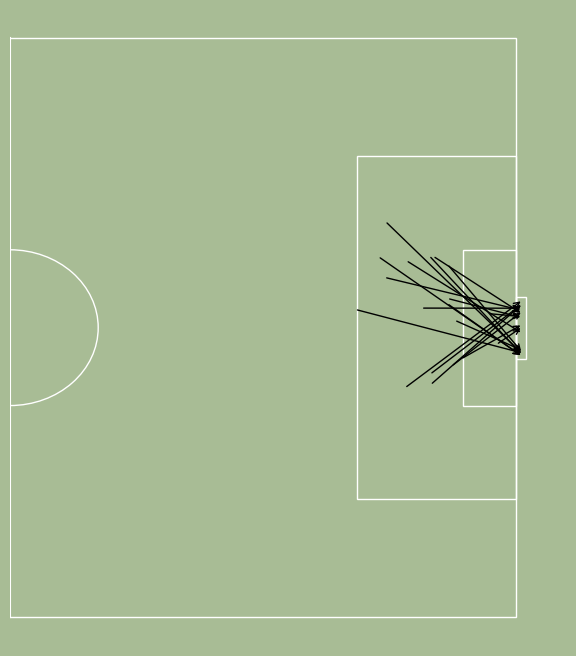

In [170]:
# Half pitch shot map 
draw_shots(df_shots)

Text(0.5, 1.0, 'Where do goal-scoring shots come from?')

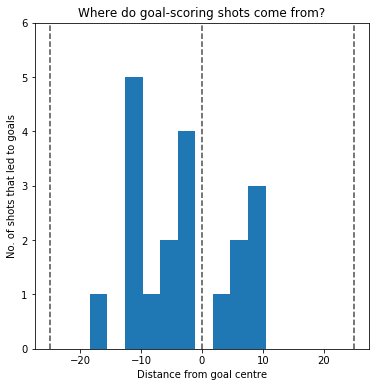

In [194]:
# Plotting shot distribution

fig,ax = plt.subplots(figsize=(6, 6))

ax.hist(50 - np.array(df_shots.y_ball))
ax.set_xlabel('Distance from goal centre')
ax.set_ylabel('No. of shots that led to goals')
ax.plot([-25,-25], [0,10], '--', color='k', alpha=0.7)
ax.plot([0,0], [0,10], '--', color='k', alpha=0.7)
ax.plot([25,25], [0,10], '--', color='k', alpha=0.7)
ax.set_ylim(0,6)
ax.set_title('Where do goal-scoring shots come from?')

(0, 6)

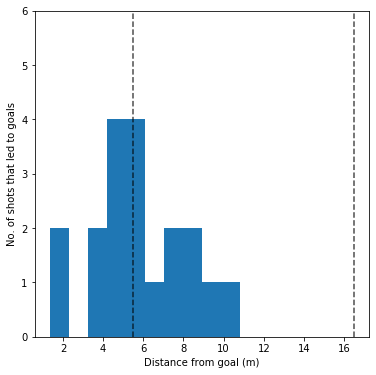

In [202]:
fig,ax = plt.subplots(figsize=(6, 6))

ax.hist((100-np.array(df_shots.x_ball))*.68)
ax.set_xlabel('Distance from goal (m)')
ax.set_ylabel('No. of shots that led to goals')
ax.plot([16.5,16.5], [0,10], '--', color='k', alpha=0.7)
ax.plot([5.5,5.5], [0,10], '--', color='k', alpha=0.7)
#ax.plot([75,75], [0,10], '--', color='k', alpha=0.7)
ax.set_ylim(0,6)

In [ ]:
# How are the shots placed? Cross goal? Center? Near post? Can define cross if y-dist traversed > (some gap btn start-end position?)

In [ ]:
# Where are they from? By who? Team effort/individual/pure luck? Any patterns emerge? Reference older goals # xG? Conversion? 

### Looking at xG

Taken from FCPython.py

In [9]:
from matplotlib.patches import Arc

def createGoalMouth(linecolor='black'):
    #Adopted from FC Python
    #Create figure
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)

    #linecolor='k'

    #Pitch Outline & Centre Line
    plt.plot([0,65],[0,0], color=linecolor)
    plt.plot([65,65],[50,0], color=linecolor)
    plt.plot([0,0],[50,0], color=linecolor)
    
    #Left Penalty Area
    plt.plot([12.5,52.5],[16.5,16.5],color=linecolor)
    plt.plot([52.5,52.5],[16.5,0],color=linecolor)
    plt.plot([12.5,12.5],[0,16.5],color=linecolor)
    
    #Left 6-yard Box
    plt.plot([41.5,41.5],[5.5,0],color=linecolor)
    plt.plot([23.5,41.5],[5.5,5.5],color=linecolor)
    plt.plot([23.5,23.5],[0,5.5],color=linecolor)
    
    #Prepare Circles
    leftPenSpot = plt.Circle((65/2,11),0.8,color=linecolor)
    
    #Draw Circles
    ax.add_patch(leftPenSpot)
    
    #Prepare Arcs
    leftArc = Arc((32.5,11),height=18.3,width=18.3,angle=0,theta1=38,theta2=142,color=linecolor)
    
    #Draw Arcs
    ax.add_patch(leftArc)
    
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax

In [418]:
with open('F:/SoccermaticsForPython/Wyscout/events_France.json') as f:
    data1 = json.load(f)
    
#Create a data set of shots.
train1= pd.DataFrame(data1)

In [420]:
train1

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],253784,"[{'y': 51, 'x': 50}, {'y': 46, 'x': 31}]",2500686,Pass,3799,1H,1.935181,85,176505119
1,8,High pass,[{'id': 1801}],29474,"[{'y': 46, 'x': 31}, {'y': 74, 'x': 68}]",2500686,Pass,3799,1H,3.599295,83,176505121
2,1,Air duel,"[{'id': 703}, {'id': 1801}]",253784,"[{'y': 74, 'x': 68}, {'y': 54, 'x': 72}]",2500686,Duel,3799,1H,6.827043,10,176505122
3,1,Air duel,"[{'id': 701}, {'id': 1802}]",56441,"[{'y': 26, 'x': 32}, {'y': 46, 'x': 28}]",2500686,Duel,3772,1H,6.985577,10,176505017
4,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",366760,"[{'y': 54, 'x': 72}, {'y': 55, 'x': 73}]",2500686,Duel,3799,1H,9.511272,11,176505124
...,...,...,...,...,...,...,...,...,...,...,...,...
632802,10,Shot,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",405977,"[{'y': 65, 'x': 87}, {'y': 100, 'x': 100}]",2501065,Shot,19830,2H,2821.203869,100,253316980
632803,9,Save attempt,"[{'id': 101}, {'id': 1208}, {'id': 1802}]",25521,"[{'y': 0, 'x': 0}, {'y': 35, 'x': 13}]",2501065,Save attempt,3795,2H,2824.817116,91,253316978
632804,8,Simple pass,[{'id': 1801}],295761,"[{'y': 52, 'x': 50}, {'y': 47, 'x': 44}]",2501065,Pass,3795,2H,2888.383858,85,253316981
632805,8,Simple pass,[{'id': 1801}],249926,"[{'y': 47, 'x': 44}, {'y': 8, 'x': 41}]",2501065,Pass,3795,2H,2889.654402,85,253316982


In [421]:
f.close()

In [264]:
#Plotting
import matplotlib.pyplot as plt
#import FCPython 
import json

#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf

# all_data=[]

# #Decide which league to load

# #Wyscout data from https://figshare.com/collections/Soccer_match_event_dataset/4415000/2
# for lg in ['England', 'Spain', 'Italy']:
#     with open(f'F:/SoccermaticsForPython/Wyscout/events_{lg}.json') as f:
#         data = json.load(f)
#         all_data = all_data+data
#     f.close()
    
# #Create a data set of shots.
# train = pd.DataFrame(all_data)

# Save all the WyScout events DF to a pickle (easy access)
#train = pd.read_pickle('xG_df')

pd.unique(train['subEventName'])
shots=train[train['subEventName']=='Shot']
shots_model=pd.DataFrame(columns=['Goal','X','Y'])

In [265]:
#Go through the dataframe and calculate X, Y co-ordinates.
#Distance from a line in the centre
#Shot angle.
#Details of tags can be found here: https://apidocs.wyscout.com/matches-wyid-events
for i,shot in shots.iterrows():
    
    header=0
    for shottags in shot['tags']:
        if shottags['id']==403:
            header=1
    #Only include non-headers        
    if not(header):        
        shots_model.at[i,'X']=100-shot['positions'][0]['x']
        shots_model.at[i,'Y']=shot['positions'][0]['y']
        shots_model.at[i,'C']=abs(shot['positions'][0]['y']-50)
    
        #Distance in metres and shot angle in radians.
        x=shots_model.at[i,'X']*105/100
        y=shots_model.at[i,'C']*65/100
        shots_model.at[i,'Distance']=np.sqrt(x**2 + y**2)
        a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
        if a<0:
            a=np.pi+a
        shots_model.at[i,'Angle'] =a
    
        #Was it a goal
        shots_model.at[i,'Goal']=0
        for shottags in shot['tags']:
                #Tags contain that its a goal
                if shottags['id']==101:
                    shots_model.at[i,'Goal']=1

#Two dimensional histogram
H_Shot=np.histogram2d(shots_model['X'], shots_model['Y'],bins=50,range=[[0, 100],[0, 100]])
goals_only=shots_model[shots_model['Goal']==1]
H_Goal=np.histogram2d(goals_only['X'], goals_only['Y'],bins=50,range=[[0, 100],[0, 100]])

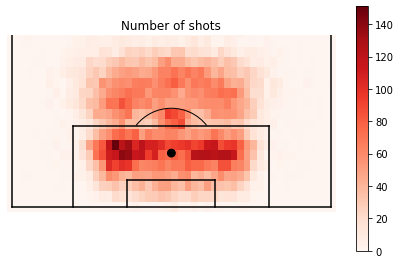

In [11]:
#Plot the number of shots from different points
fig,ax = createGoalMouth()
pos=ax.imshow(H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of shots')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
fig.savefig('Output/NumberOfShots.pdf', dpi=None, bbox_inches="tight")   

C:\Users\Gerald Lim\Anaconda3\envs\mlpy\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


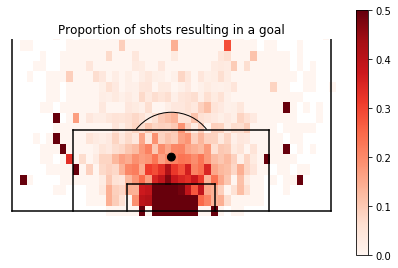

In [12]:
#Plot the probability of scoring from different points
(fig,ax) = createGoalMouth()
pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax)
ax.set_title('Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
fig.savefig('Output/ProbabilityOfScoring.pdf', dpi=None, bbox_inches="tight")   

In [248]:
# Do Liverpoo tend to score off high quality chances? Can see the max,min of a 3D xG fitted plot...
# C0mpare w stats from understat? Do Liverpool create many

### Build the xG model by fitting PDFS for goal probability against distance and angle

In [269]:
shots_dist = np.round(np.array(shots_model['Distance']))
goals_dist = np.round(np.array(goals_only['Distance']))

In [270]:
# Create Histograms
H_Goal_Dist = np.histogram(goals_dist, bins=int(np.max(goals_dist)-1))
H_Shot_Dist = np.histogram(shots_dist, bins=int(np.max(shots_dist)-1))

C:\Users\Gerald Lim\Anaconda3\envs\mlpy\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'Distance from goal (m)')

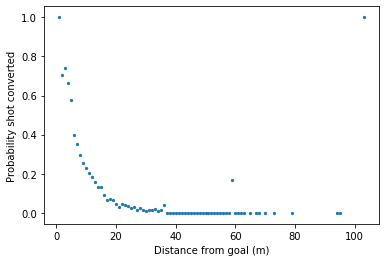

In [48]:
plt.scatter(H_Shot_Dist[1][:-1], H_Goal_Dist[0]/H_Shot_Dist[0], s=5)
plt.ylabel('Probability shot converted')
plt.xlabel('Distance from goal (m)')

In [271]:
from scipy import stats
x = H_Shot_Dist[1][:-1]
y = H_Goal_Dist[0]/H_Shot_Dist[0]

# Set all nan that arise from 0/0 to 0
y_new = [i if np.isnan(i) == False else 0. for i in y]

# Need to filter out the -np.inf that arise from doing log(0)
slope, intercept, r_value, p_value, std_err = stats.linregress(x[np.log(y_new) != -np.inf],np.log(y_new)[np.log(y_new) != -np.inf])

C:\Users\Gerald Lim\Anaconda3\envs\mlpy\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Gerald Lim\Anaconda3\envs\mlpy\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [50]:
# Try Theil-sen regression to minimise outlier effect

res = stats.theilslopes(np.log(y_new)[np.log(y_new) != -np.inf], x[np.log(y_new) != -np.inf], 0.95)

C:\Users\Gerald Lim\Anaconda3\envs\mlpy\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Users\Gerald Lim\Anaconda3\envs\mlpy\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


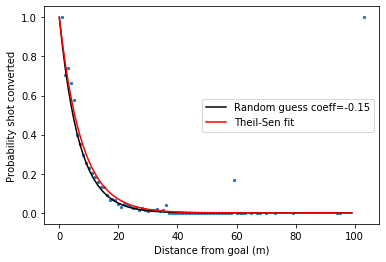

In [54]:
plt.scatter(H_Shot_Dist[1][:-1], H_Goal_Dist[0]/H_Shot_Dist[0], s=5)
plt.ylabel('Probability shot converted')
plt.xlabel('Distance from goal (m)')
plt.plot(np.arange(100), [np.exp(-0.15*x) for x in np.arange(100)], 'k', label = 'Random guess coeff=-0.15')
plt.plot(np.arange(100), [np.exp(-0.1327*x) for x in np.arange(100)], 'r', label = 'Theil-Sen fit')
plt.legend()

#### Shot Angle

In [272]:
shots_a = np.round(np.array(shots_model['Angle'])*180/np.pi)
goals_a = np.round(np.array(goals_only['Angle'])*180/np.pi)

In [273]:
# Create Histograms
H_Goal_A = np.histogram(goals_a, bins=147)
H_Shot_A = np.histogram(shots_a, bins=147)

C:\Users\Gerald Lim\Anaconda3\envs\mlpy\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'Shot Angle (deg)')

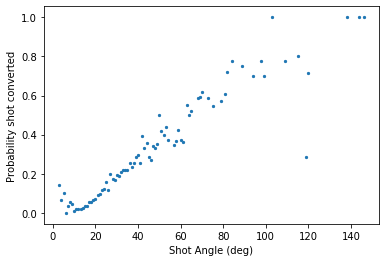

In [274]:
plt.scatter(H_Shot_A[1][1:-1], (H_Goal_A[0][1:]/H_Shot_A[0][1:]), s=5)
plt.ylabel('Probability shot converted')
plt.xlabel('Shot Angle (deg)')

In [277]:
x1 = H_Shot_A[1][1:-1]
y1 = H_Goal_A[0][1:]/H_Shot_A[0][1:]  # [1:] to ignore angle of 0 

# Set all nan that arise from 0/0 to 0
y1_new = [i if np.isnan(i) == False else 0. for i in y1]

C:\Users\Gerald Lim\Anaconda3\envs\mlpy\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [276]:
stats.linregress(x1[np.array(y1_new) > 0],np.array(y1_new)[np.array(y1_new) > 0])

LinregressResult(slope=0.0073224509872822025, intercept=-0.014036835936118375, rvalue=0.9386468824027014, pvalue=8.3051451859316e-38, stderr=0.0003046313559064963)

In [556]:
stats.theilslopes( np.array(y1_new)[np.array(y1_new) > 0], x1[np.array(y1_new) > 0], 0.95)

(0.007541232638888889,
 -0.0642730034722222,
 0.006753246753246752,
 0.00856851411084665)

C:\Users\Gerald Lim\Anaconda3\envs\mlpy\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


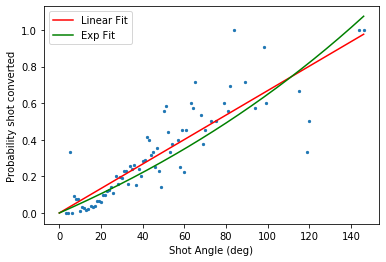

In [573]:
plt.scatter(H_Shot_A[1][1:-1], (H_Goal_A[0][1:]/H_Shot_A[0][1:]), s=5)
plt.ylabel('Probability shot converted')
plt.xlabel('Shot Angle (deg)')

#plt.plot(np.arange(147), [0.0075*x for x in np.arange(147)], 'k', label = 'Random guess coeff=-0.15')
plt.plot(np.arange(147), [0.00669*x for x in np.arange(147)], 'r', label = 'Linear Fit')

plt.plot(np.arange(147), np.array([np.exp(0.005*x) for x in np.arange(147)])-1, 'g', label = 'Exp Fit')

#plt.plot(np.arange(66), [np.exp(-0.1268*x) for x in np.arange(66)], 'r', label = 'Theil-Sen fit')
plt.legend()

#### 2-D Probability Map of goal probability

In [69]:
H_Shots_AD = np.histogram2d(shots_dist, shots_a, bins=[103,147])
H_Goals_AD = np.histogram2d(goals_dist, goals_a, bins=[103,147])

In [81]:
H_Shots_AD[0][:,1:].shape

(103, 146)

C:\Users\Gerald Lim\Anaconda3\envs\mlpy\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Probablity of shot converted')

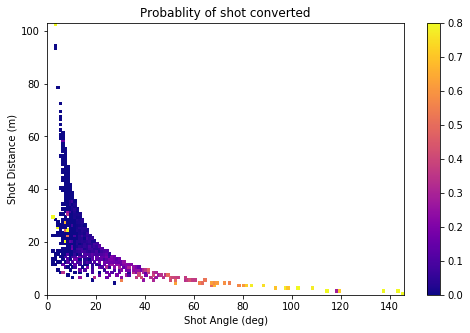

In [82]:
fig, ax = plt.subplots(figsize=(8,5))
# Ignore angle = 0 
c = ax.pcolor(H_Goals_AD[0][:,1:]/H_Shots_AD[0][:,1:], cmap = 'plasma', vmin=0, vmax=0.8)

ax.set_xlabel('Shot Angle (deg)')
ax.set_ylabel('Shot Distance (m)')

fig.colorbar(c)

ax.set_title('Probablity of shot converted')

## 1. Trying to fit with GLM (Easy way out)
Credit: Friends for Tracking xG tutorial part 2

In [267]:
shots_model.head()

,Goal,X,Y,C,Distance,Angle
46,1,12,41,9.0,13.891814,0.474451
62,0,15,52,2.0,15.803560,0.453823
128,0,19,33,17.0,22.805811,0.280597
249,0,25,30,20.0,29.292704,0.223680
394,0,10,39,11.0,12.703248,0.479051


In [268]:
# A general model for fitting goal probability
# List the model variables you want here
model_variables = ['Angle','Distance']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]


#Fit the model
test_model = smf.glm(formula="Goal ~ " + model, data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                21180
Model:                                GLM   Df Residuals:                    21177
Model Family:                    Binomial   Df Model:                            2
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -5711.6
Date:                    Sun, 10 May 2020   Deviance:                       11423.
Time:                            19:24:37   Pearson chi2:                 3.18e+05
No. Iterations:                         7                                         
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [269]:
#Return xG value for more general model
def calculate_xG(sh):    
    bsum=b[0]
    for i,v in enumerate(model_variables):
        bsum=bsum+b[i+1]*sh[v]
    xG = 1/(1+np.exp(bsum)) 
    return xG   

#Add an xG to my dataframe
xG=shots_model.apply(calculate_xG, axis=1) 
shots_model = shots_model.assign(xG=xG)

In [319]:
np.mean(shots_model[shots_model.Goal == 1].xG)

0.2328853938268857

{'whiskers': [<matplotlib.lines.Line2D at 0x12fb0ad2860>,
 'caps': [<matplotlib.lines.Line2D at 0x12fb0ad2550>,
 'boxes': [<matplotlib.lines.Line2D at 0x12fb0ad2da0>],
 'medians': [<matplotlib.lines.Line2D at 0x12fb0a8dd68>],
 'fliers': [<matplotlib.lines.Line2D at 0x12fb0a8d898>],
 'means': []}

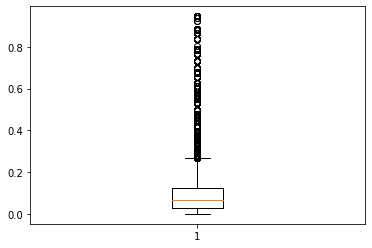

In [322]:
#plt.boxplot(shots_model[shots_model.Goal == 1].xG)
plt.boxplot(shots_model.xG)

{'whiskers': [<matplotlib.lines.Line2D at 0x12fb0bb50b8>,
 'caps': [<matplotlib.lines.Line2D at 0x12fb0bb5518>,
 'boxes': [<matplotlib.lines.Line2D at 0x12fb0d75518>],
 'medians': [<matplotlib.lines.Line2D at 0x12fb0bb53c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x12fb0d5c160>],
 'means': []}

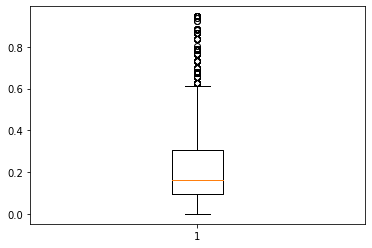

In [323]:
plt.boxplot(shots_model[shots_model.Goal == 1].xG)

#### Spatial Map of xG

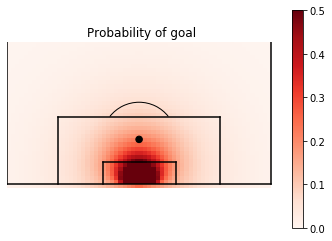

In [285]:
#Create a 2D map of xG
pgoal_2d=np.zeros((65,65))
for x in range(65):
    for y in range(65):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-65/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-65/2)**2)
        sh['D2'] = x**2 + abs(y-65/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-65/2)
        sh['C2'] = (y-65/2)**2
        
        pgoal_2d[x,y] =  calculate_xG(sh)

fig,ax = createGoalMouth()
pos=ax.imshow(pgoal_2d, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of goal')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
fig.savefig('Output/goalprobfor_' + model  + '.pdf', dpi=None, bbox_inches="tight")   

### 2. Fit via sklearn multiple regression

In [290]:
from sklearn import linear_model

X = shots_model[['Angle','Distance']] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = shots_model['Goal']
 
# with sklearn
regr = linear_model.LogisticRegression()
regr.fit(X, list(Y))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [292]:
regr.predict_proba([[0.470095,13.419803]])

array([[0.85919981, 0.14080019]])

### 3. Try a Random Forest?

In [312]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X,list(Y))

In [314]:
clf.predict_proba([[0.470095,13.419803]])

array([[0.78, 0.22]])

In [315]:
clf.predict_proba([[0.720110,8.644362]])

array([[0.85185185, 0.14814815]])

In [316]:
from sklearn.ensemble import RandomForestClassifier

clf1 = RandomForestClassifier(max_depth=2, random_state=0)
clf1.fit(X, list(Y))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [319]:
clf1.predict_proba([[0.720110,8.644362]])

array([[0.72516961, 0.27483039]])

In [ ]:
classifier = XGBClassifier(objective='binary:logistic', max_depth=5, n_estimators=100)
classifier.fit(X_train, y_train)

In [215]:
# Import XGBoost classifier
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

## Calculating xG for the 19 goals scored

#### Create a usable dataframe of the 19 goals scored (same format as shots_model)

In [276]:
def angle(x,y):
    '''
    where x n y are the actual (in m) coordinate positions, assuming a 105x65 m pitch, y referenced from pitch middle
    '''
    ang = (np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2)))
    if ang < 0:
        ang+= np.pi
    return ang

In [277]:
df_shots_model = df_shots[['Goal','x_ball', 'y_ball']]

In [278]:
df_shots_model['C']=abs(df_shots_model['y_ball']-50)

In [279]:
x=(100-df_shots_model['x_ball'])*105/100
y=df_shots_model['C']*65/100
df_shots_model['Distance']=np.sqrt(x**2 + y**2)

df_shots_model['Angle'] = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))

In [280]:
df_shots_model.head()

,Goal,x_ball,y_ball,C,Distance,Angle
37,Liverpool [3] - 0 Bournemouth,88.980532,39.541178,10.458822,13.419803,0.470095
4,Bayern 0 - [1] Liverpool,87.053896,68.421886,18.421886,18.115266,0.306178
93,Fulham 0 - [1] Liverpool,93.173892,55.073791,5.073791,7.889764,0.821040
147,Southampton 1 - [2] Liverpool,84.060687,53.178407,3.178407,16.863311,0.424603
107,Liverpool [2] - 0 Porto,97.264316,52.429225,2.429225,3.277850,-1.445365


### 1. Using the FoT xG model from tutorial

In [281]:
df_shots_model.insert(5, "xG",  df_shots_model.apply(calculate_xG, axis=1) , True) 

In [282]:
df_shots_model.sort_values('xG')

,Goal,x_ball,y_ball,C,Distance,xG,Angle
107,Liverpool [2] - 0 Porto,97.264316,52.429225,2.429225,3.277850,0.024040,-1.445365
17,Liverpool [2] - 1 Newcastle,98.023572,47.044499,2.955501,2.827931,0.035179,-1.229343
4,Bayern 0 - [1] Liverpool,87.053896,68.421886,18.421886,18.115266,0.069351,0.306178
18,Liverpool [1] - 0 Watford,86.350274,62.332494,12.332494,16.421647,0.093094,0.388560
147,Southampton 1 - [2] Liverpool,84.060687,53.178407,3.178407,16.863311,0.093728,0.424603
137,Porto 0 - [2] Liverpool,86.952695,58.714810,8.714810,14.824607,0.119576,0.452323
73,Liverpool [2] - 1 Chelsea,89.108025,61.642652,11.642652,13.713704,0.132344,0.446934
37,Liverpool [3] - 0 Bournemouth,88.980532,39.541178,10.458822,13.419803,0.140543,0.470095
20,Bournemouth 0 - 3 Liverpool,91.388232,62.487592,12.487592,12.151084,0.156097,0.458051
69,Liverpool [1] - 0 Everton,91.761113,62.403225,12.403225,11.825154,0.162315,0.464310


(array([2., 3., 3., 3., 2., 1., 1., 2., 1., 1.]),
 array([0.02403993, 0.06776507, 0.1114902 , 0.15521534, 0.19894048,
        0.24266562, 0.28639076, 0.3301159 , 0.37384103, 0.41756617,
        0.46129131]),
 <a list of 10 Patch objects>)

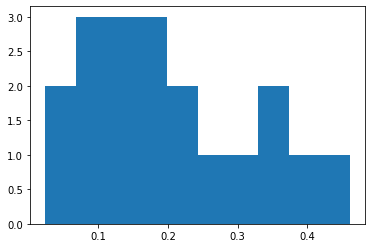

In [285]:
#plt.hist(shots_model.xG)
plt.hist(df_shots_model.sort_values('xG').xG)

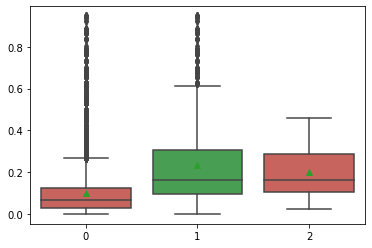

In [328]:
import seaborn as sns

sns.boxplot(
    data=[shots_model.sort_values('xG').xG, shots_model[shots_model.Goal == 1].xG, df_shots_model.sort_values('xG').xG],
    palette=[sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"]],
    showmeans=True,
)


#plt.boxplot(df_shots_model.sort_values('xG').xG)

### 2. Using the sklearn multiple logistic regression model

### 3. Using the sklearn Random Forest xG model

# Pitch Control

### 1. Data Cleaning

#### Reformatting the Liverpool Data csv into the Metrica Format 

- At the moment there are two games in our standard CSV format, in the coming days we will add the same data in the standar FIFA format.
- The data of these two games is anonymized, meaning there are no references to the names of players, teams or competitions.
- You'll see the data goes from 0 to 1 on each axis. The coordinate (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.
- The dimensions of the field are the same for both games: 105x68 meters.
- For the events, in the documentation folder you can find a pdf file with the definition and explanation of all our events types and subtypes.
- Tracking and event data are synchronized.

In [94]:
# Re-using the Leicester 0 - [3] Liverpool dataframe from before
data = pd.read_csv('../datasets/positional_data/liverpool_2019.csv', index_col=('play'))

play = 'Leicester 0 - [3] Liverpool' 

# https://www.youtube.com/watch?v=TQjqT17gO9A (highlights)

dfo = data.loc[play]
dfo.head()

,Unnamed: 0,bgcolor,dx,dy,edgecolor,frame,player,player_num,team,x,y,z
play,,,,,,,,,,,,
Leicester 0 - [3] Liverpool,0,NaN,0.0,0.0,NaN,0,0,NaN,NaN,80.255236,39.047528,0.0
Leicester 0 - [3] Liverpool,1,NaN,0.0,0.0,NaN,1,0,NaN,NaN,80.255236,39.047528,0.0
Leicester 0 - [3] Liverpool,2,NaN,0.0,0.0,NaN,2,0,NaN,NaN,80.255236,39.047528,0.0
Leicester 0 - [3] Liverpool,3,NaN,0.0,0.0,NaN,3,0,NaN,NaN,80.255236,39.047528,0.0
Leicester 0 - [3] Liverpool,4,NaN,0.0,0.0,NaN,4,0,NaN,NaN,80.255236,39.047528,0.0


In [141]:
atk_opp_split = dfo[['player','team']].groupby('player').sum()

In [150]:
type(row[0])

str

In [153]:
liv = [] 
opp = []

for index,row in atk_opp_split.iterrows():
    if 'attack' in str(row[0]):
        liv.append(index)
    elif 'defense' in str(row[0]):
        opp.append(index)

In [90]:
dfo.reset_index(drop=True, inplace=True)

df = dfo[['frame','player','x','y']]
df = df.set_index('player')

df.head()

,frame,x,y
player,,,
0,0,80.255236,39.047528
0,1,80.255236,39.047528
0,2,80.255236,39.047528
0,3,80.255236,39.047528
0,4,80.255236,39.047528


In [91]:
df_t = pd.DataFrame()

df_t = df_t.append(df[df.frame == 0].drop('frame',axis=1).stack().to_frame().T)
df_t = df_t.append(df[df.frame == 1].drop('frame',axis=1).stack().to_frame().T)

df_t.head()

player      0                     13                   65               \
                x          y          x          y         x         y   
0       80.255236  39.047528  74.863774  38.671849  77.77435  8.867034   
0       80.255236  39.047528  74.863774  38.671849  77.77435  8.867034   

player      379                   380               ...      9624              \
                x          y          x          y  ...          x          y   
0       83.654734  56.634359  86.010594  49.620907  ...  64.897959  68.697479   
0       83.654734  56.634359  86.010594  49.620907  ...  64.897959  68.697479   

player      9625                 9626                  9627              \
                x         y          x          y          x          y   
0       59.047619  47.89916  53.741497  53.361345  64.489796  82.983193   
0       59.047619  47.89916  53.741497  53.361345  64.489796  82.983193   

player      10267            
                x         y  
0       97.611697  48.67617  
0       97.611697  48.67617  

[2 rows x 44 columns]

In [126]:
frames = df.frame.unique()
df_t = pd.DataFrame()

for f in frames:
    df_t = df_t.append(df[df.frame == f].drop('frame',axis=1).stack().to_frame().T)
    
df_t['frame']=frames


df_t.head()

player          0                    13                   65            \
                x          y          x          y         x         y   
0       80.255236  39.047528  74.863774  38.671849  77.77435  8.867034   
0       80.255236  39.047528  74.863774  38.671849  77.77435  8.867034   
0       80.255236  39.047528  74.863774  38.671849  77.77435  8.867034   
0       80.255236  39.047528  74.863774  38.671849  77.77435  8.867034   
0       80.255236  39.047528  74.863774  38.671849  77.77435  8.867034   

player        379                   380             ...       9624       9625  \
                x          y          x          y  ...          y          x   
0       83.654734  56.634359  86.010594  49.620907  ...  68.697479  59.047619   
0       83.654734  56.634359  86.010594  49.620907  ...  68.697479  59.047619   
0       83.654734  56.634359  86.010594  49.620907  ...  68.697479  59.047619   
0       83.654734  56.634359  86.010594  49.620907  ...  68.697479  59.047619   
0       83.654734  56.634359  86.010594  49.620907  ...  68.697479  59.047619   

player                 9626                  9627                 10267  \
               y          x          y          x          y          x   
0       47.89916  53.741497  53.361345  64.489796  82.983193  97.611697   
0       47.89916  53.741497  53.361345  64.489796  82.983193  97.611697   
0       47.89916  53.741497  53.361345  64.489796  82.983193  97.611697   
0       47.89916  53.741497  53.361345  64.489796  82.983193  97.611697   
0       47.89916  53.741497  53.361345  64.489796  82.983193  97.611697   

player           frame  
               y        
0       48.67617     0  
0       48.67617     1  
0       48.67617     2  
0       48.67617     3  
0       48.67617     4  

[5 rows x 45 columns]

Transform (x,y) such that (0,0) is the center circle, for feeding into mvel.calc_player_velocities. Original Last Row data uses a (100,100) grid, with origin at bottom left of pitch. 

In [127]:
field_dimen=(1.05,0.68)

# Convert to metres n place origin at centre circle 
x_columns = [c for c in df_t.columns if c[-1].lower()=='x']
y_columns = [c for c in df_t.columns if c[-1].lower()=='y']
df_t[x_columns] = ( df_t[x_columns]-50 ) * field_dimen[0]
df_t[y_columns] = ( df_t[y_columns]-50 ) * field_dimen[1]

In [128]:
df_t

player          0                   13                   65             \
                x         y          x         y          x          y   
0       31.767998 -7.447681  26.106963 -7.703142  29.163067 -27.970417   
0       31.767998 -7.447681  26.106963 -7.703142  29.163067 -27.970417   
0       31.767998 -7.447681  26.106963 -7.703142  29.163067 -27.970417   
0       31.767998 -7.447681  26.106963 -7.703142  29.163067 -27.970417   
0       31.767998 -7.447681  26.106963 -7.703142  29.163067 -27.970417   
..            ...       ...        ...       ...        ...        ...   
0       53.214286 -3.428571  45.127348  4.577747  50.357143 -17.000000   
0       53.214286 -3.428571  45.127348  4.577747  50.357143 -17.000000   
0       53.214286 -3.428571  45.127348  4.577747  50.357143 -17.000000   
0       53.214286 -3.428571  45.127348  4.577747  50.357143 -17.000000   
0       53.214286 -3.428571  45.127348  4.577747  50.357143 -17.000000   

player        379                  380            ...       9624 9625  \
                x         y          x         y  ...          y    x   
0       35.337470  4.511364  37.811124 -0.257783  ...  12.714286  9.5   
0       35.337470  4.511364  37.811124 -0.257783  ...  12.714286  9.5   
0       35.337470  4.511364  37.811124 -0.257783  ...  12.714286  9.5   
0       35.337470  4.511364  37.811124 -0.257783  ...  12.714286  9.5   
0       35.337470  4.511364  37.811124 -0.257783  ...  12.714286  9.5   
..            ...       ...        ...       ...  ...        ...  ...   
0       47.554557  3.198064  47.788231 -1.280889  ...   7.142857  9.5   
0       47.554557  3.198064  47.788231 -1.280889  ...   7.142857  9.5   
0       47.554557  3.198064  47.788231 -1.280889  ...   7.142857  9.5   
0       47.554557  3.198064  47.788231 -1.280889  ...   7.142857  9.5   
0       47.554557  3.198064  47.788231 -1.280889  ...   7.142857  9.5   

player                9626                 9627                 10267  \
               y         x         y          x          y          x   
0      -1.428571  3.928571  2.285714  15.214286  22.428571  49.992282   
0      -1.428571  3.928571  2.285714  15.214286  22.428571  49.992282   
0      -1.428571  3.928571  2.285714  15.214286  22.428571  49.992282   
0      -1.428571  3.928571  2.285714  15.214286  22.428571  49.992282   
0      -1.428571  3.928571  2.285714  15.214286  22.428571  49.992282   
..           ...       ...       ...        ...        ...        ...   
0      -1.428571  3.928571  2.285714  25.357143  19.000000  51.161067   
0      -1.428571  3.928571  2.285714  25.357143  19.000000  51.161067   
0      -1.428571  3.928571  2.285714  25.357143  19.000000  51.161067   
0      -1.428571  3.928571  2.285714  25.357143  19.000000  51.161067   
0      -1.428571  3.928571  2.285714  25.357143  19.000000  51.161067   

player           frame  
               y        
0      -0.900204     0  
0      -0.900204     1  
0      -0.900204     2  
0      -0.900204     3  
0      -0.900204     4  
..           ...   ...  
0       2.529840   120  
0       2.529840   121  
0       2.529840   122  
0       2.529840   123  
0       2.529840   124  

[125 rows x 45 columns]

In [166]:
# Segregate
liv_columns = [c for c in df_t.columns if c[0] in liv]
opp_columns = [c for c in df_t.columns if c[0] in opp]

df_t[liv_columns].head()

player       13                   65                    1848            \
                x         y          x          y          x         y   
0       26.106963 -7.703142  29.163067 -27.970417  28.789455  1.652604   
0       26.106963 -7.703142  29.163067 -27.970417  28.789455  1.652604   
0       26.106963 -7.703142  29.163067 -27.970417  28.789455  1.652604   
0       26.106963 -7.703142  29.163067 -27.970417  28.789455  1.652604   
0       26.106963 -7.703142  29.163067 -27.970417  28.789455  1.652604   

player       2067                  2937                 5326            \
                x          y          x         y          x         y   
0       33.265306  17.063947  31.767998 -7.447681  34.644466 -4.675265   
0       33.265306  17.063947  31.767998 -7.447681  34.644466 -4.675265   
0       33.265306  17.063947  31.767998 -7.447681  34.644466 -4.675265   
0       33.265306  17.063947  31.767998 -7.447681  34.644466 -4.675265   
0       33.265306  17.063947  31.767998 -7.447681  34.644466 -4.675265   

player      8101                 9623                 9626            \
               x         y          x          y         x         y   
0       6.071429 -8.857143  11.928571  12.714286  3.928571  2.285714   
0       6.071429 -8.857143  11.928571  12.714286  3.928571  2.285714   
0       6.071429 -8.857143  11.928571  12.714286  3.928571  2.285714   
0       6.071429 -8.857143  11.928571  12.714286  3.928571  2.285714   
0       6.071429 -8.857143  11.928571  12.714286  3.928571  2.285714   

player       9627             
                x          y  
0       15.214286  22.428571  
0       15.214286  22.428571  
0       15.214286  22.428571  
0       15.214286  22.428571  
0       15.214286  22.428571

In [174]:
ball_col = [c for c in df_t.columns if c[0] == 0]

In [308]:
liv_track = pd.concat([df_t[liv_columns], df_t[ball_col]],axis=1)
opp_track = pd.concat([df_t[opp_columns], df_t[ball_col]],axis=1)

In [309]:
newlivcolum = ['Away_'+str(x[0])+'_'+x[1] for x in liv_columns] + ['ball_x', 'ball_y']

In [279]:
newoppcolum = ['Home_'+str(x[0])+'_'+x[1] for x in opp_columns] + ['ball_x', 'ball_y']

In [182]:
liv_track.to_csv('Leicester 0 - [3] Liverpool_LIV.csv')

Renaming the columns

In [310]:
liv_track.columns = newlivcolum

In [311]:
liv_track = liv_track.reset_index()

In [312]:
liv_track1 = liv_track.drop('index',axis=1)

In [314]:
liv_track1.insert(0, "Period", [1]*len(liv_track1), True) 
liv_track1.insert(1, "Time [s]",np.array(liv_track1.index)/20, True) 

In [315]:
liv_track1.index.name = 'Frame'

In [316]:
liv_track1

,Period,Time [s],Away_13_x,Away_13_y,Away_65_x,Away_65_y,Away_1848_x,Away_1848_y,Away_2067_x,Away_2067_y,...,Away_8101_x,Away_8101_y,Away_9623_x,Away_9623_y,Away_9626_x,Away_9626_y,Away_9627_x,Away_9627_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
0,1,0.00,26.106963,-7.703142,29.163067,-27.970417,28.789455,1.652604,33.265306,17.063947,...,6.071429,-8.857143,11.928571,12.714286,3.928571,2.285714,15.214286,22.428571,31.767998,-7.447681
1,1,0.05,26.106963,-7.703142,29.163067,-27.970417,28.789455,1.652604,33.265306,17.063947,...,6.071429,-8.857143,11.928571,12.714286,3.928571,2.285714,15.214286,22.428571,31.767998,-7.447681
2,1,0.10,26.106963,-7.703142,29.163067,-27.970417,28.789455,1.652604,33.265306,17.063947,...,6.071429,-8.857143,11.928571,12.714286,3.928571,2.285714,15.214286,22.428571,31.767998,-7.447681
3,1,0.15,26.106963,-7.703142,29.163067,-27.970417,28.789455,1.652604,33.265306,17.063947,...,6.071429,-8.857143,11.928571,12.714286,3.928571,2.285714,15.214286,22.428571,31.767998,-7.447681
4,1,0.20,26.106963,-7.703142,29.163067,-27.970417,28.789455,1.652604,33.265306,17.063947,...,6.071429,-8.857143,11.928571,12.714286,3.928571,2.285714,15.214286,22.428571,31.767998,-7.447681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,1,6.00,45.127348,4.577747,50.357143,-17.000000,47.578327,-0.420661,46.445945,8.325092,...,6.071429,-8.857143,18.214286,8.285714,3.928571,2.285714,25.357143,19.000000,53.214286,-3.428571
121,1,6.05,45.127348,4.577747,50.357143,-17.000000,47.578327,-0.420661,46.445945,8.325092,...,6.071429,-8.857143,18.214286,8.285714,3.928571,2.285714,25.357143,19.000000,53.214286,-3.428571
122,1,6.10,45.127348,4.577747,50.357143,-17.000000,47.578327,-0.420661,46.445945,8.325092,...,6.071429,-8.857143,18.214286,8.285714,3.928571,2.285714,25.357143,19.000000,53.214286,-3.428571


Period	Time [s]	Home_11_x	Home_11_y	Home_1_x	Home_1_y	Home_2_x	Home_2_y	Home_3_x	Home_3_y	...	Home_10_x	Home_10_y	Home_12_x	Home_12_y	Home_13_x	Home_13_y	Home_14_x	Home_14_y	ball_x	ball_y

In [317]:
# Repeat for Opponent 

opp_track.columns = newoppcolum
opp_track = opp_track.reset_index()
opp_track1 = opp_track.drop('index',axis=1)
opp_track1.insert(0, "Period", [1]*len(opp_track1), True) 
opp_track1.insert(1, "Time [s]",np.array(opp_track1.index)/20, True) 
opp_track1.index.name = 'Frame'

In [318]:
opp_track1.head()

,Period,Time [s],Home_379_x,Home_379_y,Home_380_x,Home_380_y,Home_381_x,Home_381_y,Home_382_x,Home_382_y,...,Home_9233_x,Home_9233_y,Home_9624_x,Home_9624_y,Home_9625_x,Home_9625_y,Home_10267_x,Home_10267_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
0,1,0.00,35.33747,4.511364,37.811124,-0.257783,36.132087,-6.008809,35.787459,-14.69522,...,22.177383,18.708156,15.642857,12.714286,9.5,-1.428571,49.992282,-0.900204,31.767998,-7.447681
1,1,0.05,35.33747,4.511364,37.811124,-0.257783,36.132087,-6.008809,35.787459,-14.69522,...,22.177383,18.708156,15.642857,12.714286,9.5,-1.428571,49.992282,-0.900204,31.767998,-7.447681
2,1,0.10,35.33747,4.511364,37.811124,-0.257783,36.132087,-6.008809,35.787459,-14.69522,...,22.177383,18.708156,15.642857,12.714286,9.5,-1.428571,49.992282,-0.900204,31.767998,-7.447681
3,1,0.15,35.33747,4.511364,37.811124,-0.257783,36.132087,-6.008809,35.787459,-14.69522,...,22.177383,18.708156,15.642857,12.714286,9.5,-1.428571,49.992282,-0.900204,31.767998,-7.447681
4,1,0.20,35.33747,4.511364,37.811124,-0.257783,36.132087,-6.008809,35.787459,-14.69522,...,22.177383,18.708156,15.642857,12.714286,9.5,-1.428571,49.992282,-0.900204,31.767998,-7.447681


### Reformatting the Events Data from the starter notebook into the Metrica Format 

Assume the only events in the Last Row dataset are passes n shots. We already computed this from before. 

In [733]:
# Slight changes in read_csv arg for now so read data again 
data = pd.read_csv('../datasets/positional_data/liverpool_2019.csv', index_col=('play', 'frame'))

play = 'Leicester 0 - [3] Liverpool' 
df = data.loc[play]

dfo.index.get_level_values('play').unique()

Index(['Leicester 0 - [3] Liverpool'], dtype='object', name='play')

In [734]:
dfo_goals = dfo.index.get_level_values('play').unique()
dfo_shots = get_shots(dfo_goals, invert = False)

dfoPossession = get_possession_df(dfo)
dfoPasses = get_passes_df(dfoPossession)

C:\Users\Gerald Lim\Anaconda3\envs\mlpy\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Gerald Lim\Anaconda3\envs\mlpy\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Gerald Lim\Anaconda3\envs\mlpy\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\User

In [735]:
dfo_shots

,Unnamed: 0,bgcolor,dif_x,dif_y,dx,dy,edgecolor,frame,frame_end,player,player_num,team,x,x_ball,x_end,y,y_ball,y_end,z,Goal
44,221.0,red,0.0,0.0,0.017511,0.064723,white,96.0,124.0,13.0,9.0,attack,93.13465,93.13465,100.680272,54.246567,54.246567,44.957983,0.0,Leicester 0 - [3] Liverpool


In [736]:
dfo_shots_form = dfo_shots[['team','frame','frame_end', 'player','x','y','x_end','y_end']]
dfo_shots_form.insert(4, "to_player", np.nan, True) 

In [737]:
dfo_shots_form = dfo_shots_form.rename(columns={"team": "Team", "frame": "Start Frame", "frame_end": "End Frame", "player": "From", "to_player": "To", "x": "Start X", "y": "Start Y", "x_end": "End X", "y_end": "End Y"})

In [738]:
dfo_shots_form 

,Team,Start Frame,End Frame,From,To,Start X,Start Y,End X,End Y
44,attack,96.0,124.0,13.0,NaN,93.13465,54.246567,100.680272,44.957983


In [739]:
dfo_shots_form.insert(1, "Type", ['SHOT'], True)
dfo_shots_form.insert(2, "Subtype", ['ON TARGET-GOAL'], True)
dfo_shots_form.insert(3, "Period", [1], True)
dfo_shots_form.insert(5, "Start Time [s]", np.array(dfo_shots_form['Start Frame'])/20 , True)
dfo_shots_form.insert(7, "End Time [s]", np.array(dfo_shots_form['End Frame'])/20, True)
dfo_shots_form.Team = 'Away'

In [740]:
dfo_shots_form

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
44,Away,SHOT,ON TARGET-GOAL,1,96.0,4.8,124.0,6.2,13.0,NaN,93.13465,54.246567,100.680272,44.957983


**Passes**

In [741]:
dfoPasses_form = dfoPasses[['from_team','from_frame','to_frame','from_player','to_player','from_x','from_y','to_x','to_y']]
dfoPasses_form

,from_team,from_frame,to_frame,from_player,to_player,from_x,from_y,to_x,to_y
0,attack,24,60.0,2937,65.0,83.3973,36.103011,92.139400,16.669171
1,attack,60,78.0,65,13.0,92.1394,16.669171,91.973975,52.775476


In [742]:
dfoPasses_form = dfoPasses_form.rename(columns={"from_team": "Team", "from_frame": "Start Frame", "to_frame": "End Frame", "from_player": "From", "to_player": "To", "from_x": "Start X", "from_y": "Start Y", "to_x": "End X", "to_y": "End Y"})

Metrica <br>
Team	Type	Subtype	Period	Start Frame	Start Time [s]	End Frame	End Time [s]	From	To	Start X	Start Y	End X	End Y

In [743]:
dfoPasses_form.insert(1, "Type", ['PASS']*len(dfoPasses_form), True)
dfoPasses_form.insert(2, "Subtype", [np.nan]*len(dfoPasses_form), True)
dfoPasses_form.insert(3, "Period", [1]*len(dfoPasses_form), True)
dfoPasses_form.insert(5, "Start Time [s]", np.array(dfoPasses_form['Start Frame'])/20 , True)
dfoPasses_form.insert(7, "End Time [s]", np.array(dfoPasses_form['End Frame'])/20, True)
dfoPasses_form.Team = 'Away'

In [744]:
dfoPasses_form

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,PASS,NaN,1,24,1.2,60.0,3.0,2937,65.0,83.3973,36.103011,92.139400,16.669171
1,Away,PASS,NaN,1,60,3.0,78.0,3.9,65,13.0,92.1394,16.669171,91.973975,52.775476


In [745]:
dfoEvents = dfoPasses_form.append(dfo_shots_form)

Transform the data such that (0,0) is centre circle

In [746]:
dfoEvents['Start X'] -= 50
dfoEvents['End X'] -= 50
dfoEvents['Start Y'] -= 50
dfoEvents['End Y'] -= 50

Scale the Data to Pitch dimensions 105 x 68

In [747]:
dfoEvents['Start X'] *= field_dimen[0]
dfoEvents['End X'] *= field_dimen[0]
dfoEvents['Start Y'] *= field_dimen[1]
dfoEvents['End Y'] *= field_dimen[1]

In [748]:
dfoEvents

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,PASS,NaN,1,24.0,1.2,60.0,3.0,2937.0,65.0,35.067165,-9.449953,44.246370,-22.664964
1,Away,PASS,NaN,1,60.0,3.0,78.0,3.9,65.0,13.0,44.246370,-22.664964,44.072673,1.887324
44,Away,SHOT,ON TARGET-GOAL,1,96.0,4.8,124.0,6.2,13.0,NaN,45.291382,2.887665,53.214286,-3.428571


In [749]:
dfoEvents['From'] = ['Player'+str(x)[:-2] if x != np.nan else x for x in dfoEvents['From']]
dfoEvents['To'] = ['Player'+str(x)[:-2] if np.isnan(x) != True else x for x in dfoEvents['To']] 

In [750]:
dfoEvents

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,PASS,NaN,1,24.0,1.2,60.0,3.0,Player2937,Player65,35.067165,-9.449953,44.246370,-22.664964
1,Away,PASS,NaN,1,60.0,3.0,78.0,3.9,Player65,Player13,44.246370,-22.664964,44.072673,1.887324
44,Away,SHOT,ON TARGET-GOAL,1,96.0,4.8,124.0,6.2,Player13,NaN,45.291382,2.887665,53.214286,-3.428571


In [569]:
# Save the Metrica Formatted DFs
liv_events2.to_pickle('Leceister 0 - [3] Liverpool_Events')
opp_track2.to_pickle('Leceister 0 - [3] Liverpool_Home')
liv_track2.to_pickle('Leceister 0 - [3] Liverpool_Away')

In [575]:
'Leceister 0 - [3] Liverpool'.split(' ').index('Liverpool')

4

In [178]:
def format_data(play):
    # Re-using the Leicester 0 - [3] Liverpool dataframe from before
    data = pd.read_csv('../datasets/positional_data/liverpool_2019.csv', index_col=('play'))

    dfo = data.loc[play]
     
    
    # Segment DF into Home and Away Teams (+ball)
    atk_opp_split = dfo[['player','team']].groupby('player').sum()

    liv = [] 
    opp = []
    for index,row in atk_opp_split.iterrows():
        if 'attack' in str(row[0]):
            liv.append(index)
        elif 'defense' in str(row[0]):
            opp.append(index)
            
    # DF shape reformatting         
    dfo.reset_index(drop=True, inplace=True)

    df = dfo[['frame','player','x','y']]
    df = df.set_index('player')

    df_t = pd.DataFrame()
    df_t = df_t.append(df[df.frame == 0].drop('frame',axis=1).stack().to_frame().T)
    df_t = df_t.append(df[df.frame == 1].drop('frame',axis=1).stack().to_frame().T)
    frames = df.frame.unique()
    df_t = pd.DataFrame()

    for f in frames:
        df_t = df_t.append(df[df.frame == f].drop('frame',axis=1).stack().to_frame().T)

    df_t['frame']=frames
    
    
    # Scale and transform the (x,y) to actual size in metres 
    field_dimen=(1.05,0.68)
    # Convert to metres n place origin at centre circle 
    x_columns = [c for c in df_t.columns if c[-1].lower()=='x']
    y_columns = [c for c in df_t.columns if c[-1].lower()=='y']
    df_t[x_columns] = ( df_t[x_columns]-50 ) * field_dimen[0]
    df_t[y_columns] = ( df_t[y_columns]-50 ) * field_dimen[1]
    
    # Get the columns for liv and opp players 
    liv_columns = [c for c in df_t.columns if c[0] in liv]
    opp_columns = [c for c in df_t.columns if c[0] in opp]
    # get the ball_x ball_y columns
    ball_col = [c for c in df_t.columns if c[0] == 0]
    # Segregate
    liv_track = pd.concat([df_t[liv_columns], df_t[ball_col]],axis=1)
    opp_track = pd.concat([df_t[opp_columns], df_t[ball_col]],axis=1)
    
    # Determine if Liverpool are the Home or Away team for the 'play'
    if play.split(' ').index('Liverpool') == 0:
        newlivcolum = ['Home_'+str(x[0])+'_'+x[1] for x in liv_columns] + ['ball_x', 'ball_y']
        newoppcolum = ['Away_'+str(x[0])+'_'+x[1] for x in opp_columns] + ['ball_x', 'ball_y']
        
    else:
        newlivcolum = ['Away_'+str(x[0])+'_'+x[1] for x in liv_columns] + ['ball_x', 'ball_y']
        newoppcolum = ['Home_'+str(x[0])+'_'+x[1] for x in opp_columns] + ['ball_x', 'ball_y']

     # Reformatting for Liverpool DF
    liv_track.columns = newlivcolum
    liv_track = liv_track.reset_index()
    liv_track1 = liv_track.drop('index',axis=1)
    liv_track1.insert(0, "Period", [1]*len(liv_track1), True) 
    liv_track1.insert(1, "Time [s]",np.array(liv_track1.index)/20, True) 
    liv_track1.index.name = 'Frame'
    
    # Repeat for Opponent DF
    opp_track.columns = newoppcolum
    opp_track = opp_track.reset_index()
    opp_track1 = opp_track.drop('index',axis=1)
    opp_track1.insert(0, "Period", [1]*len(opp_track1), True) 
    opp_track1.insert(1, "Time [s]",np.array(opp_track1.index)/20, True) 
    opp_track1.index.name = 'Frame'

    return liv_track1, opp_track1

In [192]:
def format_events(play):
    # Re-using the Leicester 0 - [3] Liverpool dataframe from before
    data = pd.read_csv('../datasets/positional_data/liverpool_2019.csv', index_col=('play'))

    dfo = data.loc[play]
    
    dfo_goals = dfo.index.get_level_values('play').unique()
    dfo_shots = get_shots(dfo_goals, invert = False)

    dfoPossession = get_possession_df(dfo)
    dfoPasses = get_passes_df(dfoPossession)
    
    # Shots
    dfo_shots_form = dfo_shots[['team','frame','frame_end', 'player','x','y','x_end','y_end']]
    dfo_shots_form.insert(4, "to_player", np.nan, True) 
    dfo_shots_form = dfo_shots_form.rename(columns={"team": "Team", "frame": "Start Frame", "frame_end": "End Frame", "player": "From", "to_player": "To", "x": "Start X", "y": "Start Y", "x_end": "End X", "y_end": "End Y"})

    dfo_shots_form.insert(1, "Type", ['SHOT'], True)
    dfo_shots_form.insert(2, "Subtype", ['ON TARGET-GOAL'], True)
    dfo_shots_form.insert(3, "Period", [1], True)
    dfo_shots_form.insert(5, "Start Time [s]", np.array(dfo_shots_form['Start Frame'])/20 , True)
    dfo_shots_form.insert(7, "End Time [s]", np.array(dfo_shots_form['End Frame'])/20, True)
     

    # Passes
    dfoPasses_form = dfoPasses[['from_team','from_frame','to_frame','from_player','to_player','from_x','from_y','to_x','to_y']]
    dfoPasses_form = dfoPasses_form.rename(columns={"from_team": "Team", "from_frame": "Start Frame", "to_frame": "End Frame", "from_player": "From", "to_player": "To", "from_x": "Start X", "from_y": "Start Y", "to_x": "End X", "to_y": "End Y"})

    dfoPasses_form.insert(1, "Type", ['PASS']*len(dfoPasses_form), True)
    dfoPasses_form.insert(2, "Subtype", [np.nan]*len(dfoPasses_form), True)
    dfoPasses_form.insert(3, "Period", [1]*len(dfoPasses_form), True)
    dfoPasses_form.insert(5, "Start Time [s]", np.array(dfoPasses_form['Start Frame'])/20 , True)
    dfoPasses_form.insert(7, "End Time [s]", np.array(dfoPasses_form['End Frame'])/20, True)
    # Determine if Liverpool are the Home or Away team for the 'play'
    if play.split(' ').index('Liverpool') == 0:
        dfo_shots_form.Team = 'Home'
        dfoPasses_form.Team = 'Home'
    else:
        dfo_shots_form.Team = 'Away'
        dfoPasses_form.Team = 'Home'
        
    dfoEvents = dfoPasses_form.append(dfo_shots_form)

    # Transform to (0,0) to centre circle
    dfoEvents['Start X'] -= 50
    dfoEvents['End X'] -= 50
    dfoEvents['Start Y'] -= 50
    dfoEvents['End Y'] -= 50

    # Scale to actual field dimensions
    field_dimen=(1.05,0.68)
    dfoEvents['Start X'] *= field_dimen[0]
    dfoEvents['End X'] *= field_dimen[0]
    dfoEvents['Start Y'] *= field_dimen[1]
    dfoEvents['End Y'] *= field_dimen[1]

    dfoEvents['From'] = ['Player'+str(x)[:-2] if x != np.nan else x for x in dfoEvents['From']]
    dfoEvents['To'] = ['Player'+str(x)[:-2] if np.isnan(x) != True else x for x in dfoEvents['To']] 
    
    return dfoEvents

## Testing the above function

In [719]:
liv_track2, opp_track2 = format_data('Liverpool [2] - 0 Man City')

In [755]:
liv_events2 = format_events('Liverpool [2] - 0 Man City')

C:\Users\Gerald Lim\Anaconda3\envs\mlpy\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Gerald Lim\Anaconda3\envs\mlpy\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Gerald Lim\Anaconda3\envs\mlpy\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\User

### Testing Time! 

In [196]:
# Import the Metrica Packages

sys.path.insert(0, os.path.abspath('../scripts/'))
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc

In [208]:
# Load the pre-saved dataframes

liv_track1 = pd.read_pickle('Output/Leceister 0 - [3] Liverpool_Away')
opp_track1 = pd.read_pickle('Output/Leceister 0 - [3] Liverpool_Home')
liv_events1 = pd.read_pickle('Output/Leceister 0 - [3] Liverpool_Events')

In [119]:
# Calculate player velocities
tracking_home = mvel.calc_player_velocities(opp_track1,smoothing=True,filter_='moving_average')
tracking_away = mvel.calc_player_velocities(liv_track1,smoothing=True,filter_='moving_average')

In [209]:
""" **** pitch control for passes leading up to goal vs Leicester **** """

# get all shots and goals in the match
shots = liv_events1[liv_events1['Type']=='SHOT']
goals = shots[shots['Subtype'].str.contains('-GOAL')].copy()

goals

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
44,Away,SHOT,ON TARGET-GOAL,1,96.0,4.8,124.0,6.2,Player13,NaN,45.291382,2.887665,53.214286,-3.428571


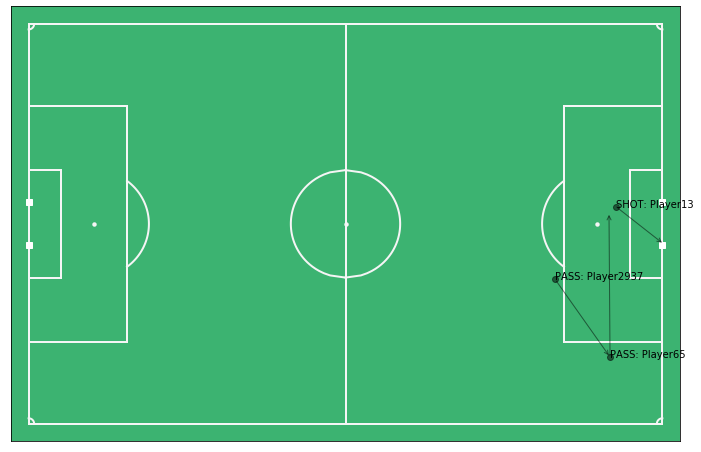

In [211]:
# plot the 3 events leading up to the second goal
fig, ax = mviz.plot_events(liv_events1, color='k', indicators = ['Marker','Arrow'], annotate=True )
fig.savefig('F:/Last-Row/notebooks/Output/EventFigs/Leceister 0 - [3] Liverpool.png')

In [124]:
# first get model parameters
params = mpc.default_model_params(3)

# evaluated pitch control surface for first pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(0, liv_events1, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28b15bed358>)

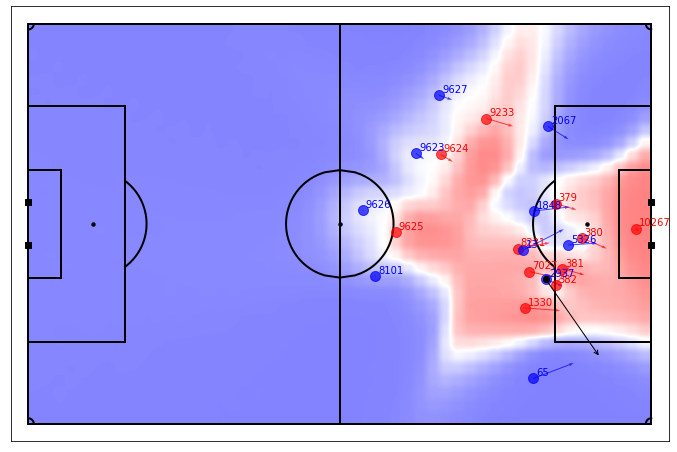

In [530]:
mviz.plot_pitchcontrol_for_event(0, dfoEvents,  tracking_home, tracking_away, PPCF, xgrid, ygrid, annotate=True )

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28b165c7208>)

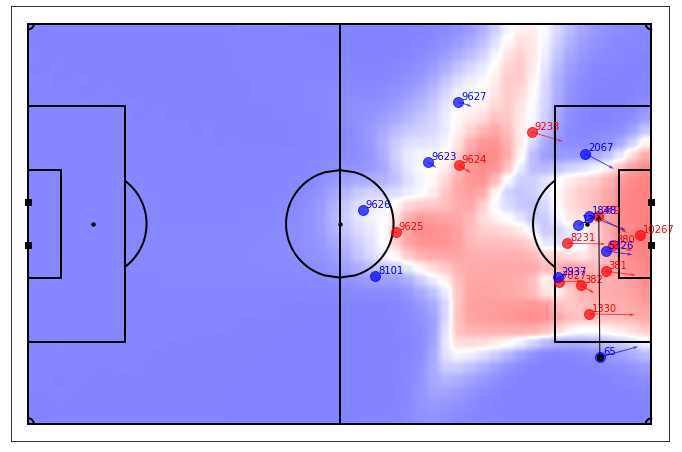

In [533]:
mviz.plot_pitchcontrol_for_event(1, dfoEvents,  tracking_home, tracking_away, PPCF, xgrid, ygrid, annotate=True )

## Need to modify the module function so that I can compute the pitch control at any frame rather than just event frames 

In [257]:
def generate_pitch_control_for_frame(frame, home_team, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50):
    """ generate_pitch_control_for_frame
    
    Evaluates pitch control surface over the entire field at the moment of the given event (determined by the index of the event passed as an input)
    
    Parameters
    -----------
        event_id: Index (not row) of the event that describes the instant at which the pitch control surface should be calculated
        events: Dataframe containing the event data
        tracking_home: tracking DataFrame for the Home team
        tracking_away: tracking DataFrame for the Away team
        params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        n_grid_cells_x: Number of pixels in the grid (in the x-direction) that covers the surface. Default is 50.
                        n_grid_cells_y will be calculated based on n_grid_cells_x and the field dimensions
        
    Returrns
    -----------
        PPCFa: Pitch control surface (dimen (n_grid_cells_x,n_grid_cells_y) ) containing pitch control probability for the attcking team.
               Surface for the defending team is just 1-PPCFa.
        xgrid: Positions of the pixels in the x-direction (field length)
        ygrid: Positions of the pixels in the y-direction (field width)

    """
    params = mpc.default_model_params(3)
    
    # get the details of the event (frame, team in possession, ball_start_position)
    ball_start_pos = np.array([tracking_home.loc[frame]['ball_x'],tracking_home.loc[frame]['ball_y']])
    # break the pitch down into a grid
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    xgrid = np.linspace( -field_dimen[0]/2., field_dimen[0]/2., n_grid_cells_x)
    ygrid = np.linspace( -field_dimen[1]/2., field_dimen[1]/2., n_grid_cells_y )
    # initialise pitch control grids for attacking and defending teams 
    PPCFa = np.zeros( shape = (len(ygrid), len(xgrid)) )
    PPCFd = np.zeros( shape = (len(ygrid), len(xgrid)) )
    # initialise player positions and velocities for pitch control calc (so that we're not repeating this at each grid cell position)
    if home_team=='Liverpool':
        attacking_players = mpc.initialise_players(tracking_home.loc[frame],'Home',params)
        defending_players = mpc.initialise_players(tracking_away.loc[frame],'Away',params)
    elif home_team=='Opp':
        defending_players = mpc.initialise_players(tracking_home.loc[frame],'Home',params)
        attacking_players = mpc.initialise_players(tracking_away.loc[frame],'Away',params)
    else:
        assert False, "Team in possession must be either home or away"
    # calculate pitch pitch control model at each location on the pitch
    for i in range( len(ygrid) ):
        for j in range( len(xgrid) ):
            target_position = np.array( [xgrid[j], ygrid[i]] )
            PPCFa[i,j],PPCFd[i,j] = mpc.calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params)
    # check probabilitiy sums within convergence
    checksum = np.sum( PPCFa + PPCFd ) / float(n_grid_cells_y*n_grid_cells_x ) 
    assert 1-checksum < params['model_converge_tol'], "Checksum failed: %1.3f" % (1-checksum)
    return PPCFa,xgrid,ygrid

In [549]:
PPCF,xgrid,ygrid = generate_pitch_control_for_frame(0, "Opp", tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)

In [301]:
def plot_pc_array(array,title,cmin=0,cmax=1, events=None, indicators = ['Marker','Arrow'], color='r', marker_style = 'o', linecolor='k', alpha = 0.8, annotate=True):
    '''
    Plot the map of any array related to Pitch Control at any instance along with the pitch
    '''
    
    # Create the Pitch
    fig = plt.figure(figsize=(8, 4), dpi=100)
    ax = fig.add_subplot(1, 1, 1)
    
    #Pitch Bounds
    ax.plot([-53,-53],[-34,34],color=linecolor)
    ax.plot([-53,53],[-34,-34],color=linecolor)
    ax.plot([-53,53],[34,34],color=linecolor)
    ax.plot([53,53],[-34,34],color=linecolor)

    
    #Left Penalty Area
    ax.plot([0-53,16.5-53],[13.85-34,13.85-34],color=linecolor)
    ax.plot([16.5-53,16.5-53],[13.85-34,54.15-34],color=linecolor)
    ax.plot([0-53,16.5-53],[54.15-34,54.15-34],color=linecolor)

    #Right Penalty Area
    ax.plot([53-16.5,53],[13.85-34,13.85-34],color=linecolor)
    ax.plot([53-16.5,53-16.5],[13.85-34,54.15-34],color=linecolor)
    ax.plot([53-16.5,53],[54.15-34,54.15-34],color=linecolor)

    #Left 6-yard Box
    ax.plot([-53,5.5-53],[24.85-34,24.85-34],color=linecolor)
    ax.plot([5.5-53,5.5-53],[24.85-34,43.15-34],color=linecolor)
    ax.plot([-53,5.5-53],[43.15-34,43.15-34],color=linecolor)

    #Right 6-yard box
    ax.plot([53-5.5,53],[24.85-34,24.85-34],color=linecolor)
    ax.plot([53-5.5,53-5.5],[24.85-34,43.15-34],color=linecolor)
    ax.plot([53-5.5,53],[43.15-34,43.15-34],color=linecolor)

    #Centre line
    ax.plot([0,0],[-34,34],color=linecolor)

    #Prepare Circles
    leftPenSpot = plt.Circle((10.97-53,0),0.8,color=linecolor)
    rightPenSpot = plt.Circle((53-10.97,0),0.8,color=linecolor)

    #Draw Circles
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Center Circle
    ax.add_patch(Ellipse((0, 0), 9.15, 9.15, ec='k', fc='none'))

    #Goals
    #Left Goal
    ax.plot([-53],[-3.66],color=linecolor,marker='s',markersize=3)
    ax.plot([-53],[3.66],color=linecolor,marker='s',markersize=3)

    #Right Goal
    ax.plot([53],[-3.66],color=linecolor,marker='s',markersize=3)
    ax.plot([53],[3.66],color=linecolor,marker='s',markersize=3)

    
    # Overlaying the PC 32x50 Array
    C = ax.pcolor(x_pc,y_pc,array, cmap='RdBu_r', vmin=cmin, vmax=cmax)
    fig.colorbar(C)
    ax.set_title(f'{title}')
    
    ax.set_ylim(-34,34)
    ax.set_xlim(-53,53)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    if isinstance(events, pd.DataFrame) == True:
    
        for i,row in events.iterrows():
            if 'Marker' in indicators:
                ax.plot(  row['Start X'], row['Start Y'], color+marker_style, alpha=alpha, markeredgecolor = 'w', markersize=9 )
            if 'Arrow' in indicators:
                ax.annotate("", xy=row[['End X','End Y']], xytext=row[['Start X','Start Y']], alpha=alpha, arrowprops=dict(alpha=alpha,arrowstyle="->",color=linecolor),annotation_clip=False)
            if annotate:
                textstring = row['Type']
                if row['Start X'] > 26:
                    ax.text( row['Start X'], row['Start Y'], textstring, fontsize=9, color=linecolor,horizontalalignment='right')
                else:
                    ax.text( row['Start X'], row['Start Y'], textstring, fontsize=9, color=linecolor, horizontalalignment='left')
    return fig

In [152]:
liv_events1

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,PASS,NaN,1,24.0,1.2,60.0,3.0,Player2937,Player65,35.067165,-9.449953,44.246370,-22.664964
1,Away,PASS,NaN,1,60.0,3.0,78.0,3.9,Player65,Player13,44.246370,-22.664964,44.072673,1.887324
44,Away,SHOT,ON TARGET-GOAL,1,96.0,4.8,124.0,6.2,Player13,NaN,45.291382,2.887665,53.214286,-3.428571


In [155]:
all_map = []
# Get every 10th frame from frame 0 (start) to 100 (~shot taken)
for i in np.arange(0,110,10):
    map_pc,x_pc,y_pc = generate_pitch_control_for_frame(i, "Opp", tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
    all_map.append(map_pc)

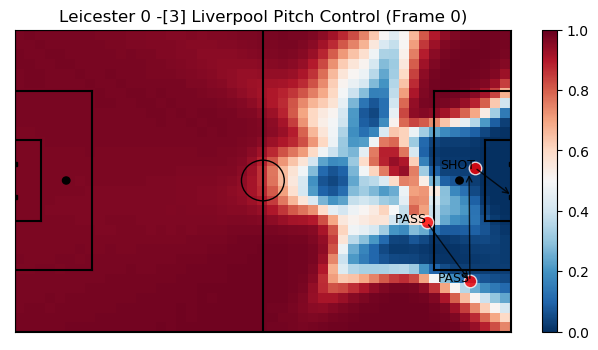

In [170]:
plot_pc_array(all_map[0],'Leicester 0 -[3] Liverpool Pitch Control (Frame 0)', events=liv_events1)

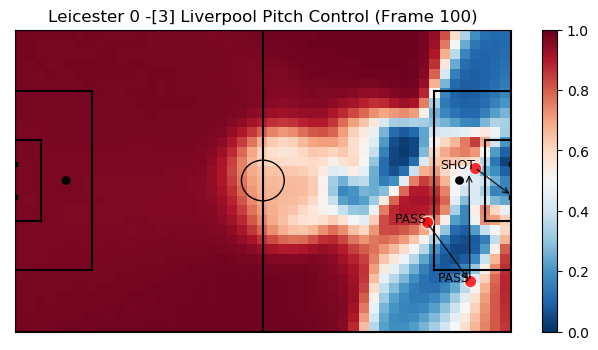

In [171]:
plot_pc_array(all_map[-1],'Leicester 0 -[3] Liverpool Pitch Control (Frame 100)', events=liv_events1)

## Gradient for every grid 

In [135]:
import scipy.stats

def pc_gain(pcs_arr):
    
    pcs_arr_flat = np.array(pcs_arr).reshape((len(pcs_arr),32*50)).T
    pc_gain = [scipy.stats.linregress(np.arange(len(pcs_arr)),y)[0] for y in pcs_arr_flat]
    pc_gain = np.array(pc_gain).reshape(32,50)
    
    return pc_gain

In [136]:
liv_lei_gain = pc_gain(all_map)

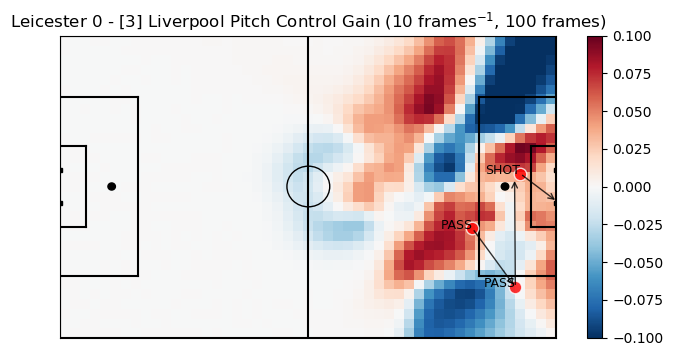

In [172]:
plot_pc_array(liv_lei_gain,'Leicester 0 - [3] Liverpool Pitch Control Gain (10 frames$^{-1}$, 100 frames)', cmin=-0.1, cmax=0.1, events=liv_events1)

## Try on another dataset

#### Liverpool 2 - [0] Man City

In [31]:
# Load the pre-saved dataframes

liv_track2 = pd.read_pickle('Liverpool [2] - 0 Man City_Home')
opp_track2 = pd.read_pickle('Liverpool [2] - 0 Man City_Away')
liv_events2 = pd.read_pickle('Liverpool [2] - 0 Man City_Events')

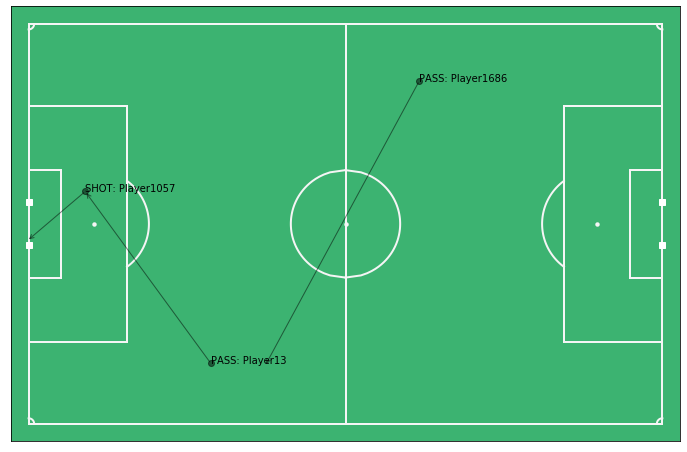

In [203]:
# plot the 3 events leading up to the second goal
fig1,ax1 = mviz.plot_events( liv_events2 , color='k', indicators = ['Marker','Arrow'], annotate=True )

In [205]:
fig1.savefig('F:/Last-Row/notebooks/Output/EventFigs/Liverpool [2] - 0 Man City.png')

In [33]:
# Calculate player velocities
tracking_home2 = mvel.calc_player_velocities(liv_track2,smoothing=True,filter_='moving_average')
tracking_away2 = mvel.calc_player_velocities(opp_track2,smoothing=True,filter_='moving_average')

In [34]:
liv_events2

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Home,PASS,NaN,1,0.0,0.0,76.0,3.8,Player1686,Player13,12.323475,24.284477,-13.446606,-24.136326
1,Home,PASS,NaN,1,100.0,5.0,140.0,7.0,Player13,Player1057,-22.550234,-23.708563,-43.540313,5.508466
26,Home,SHOT,ON TARGET-GOAL,1,140.0,7.0,166.0,8.3,Player1057,NaN,-43.540313,5.508466,-53.214286,-2.857143


In [40]:
# first get model parameters (run if not loaded yet)
params = mpc.default_model_params(3)

In [41]:
all_map2 = []
# Get every 10th frame from frame 0 (start) to 140 (shot taken)
for i in np.arange(0,150,10):
    map_pc,x_pc,y_pc = generate_pitch_control_for_frame(i, "Liverpool", tracking_home2, tracking_away2, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
    all_map2.append(map_pc)

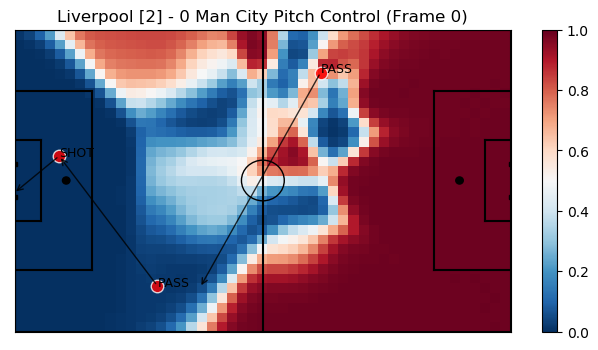

In [173]:
plot_pc_array(all_map2[0],'Liverpool [2] - 0 Man City Pitch Control (Frame 0)', events=liv_events2)

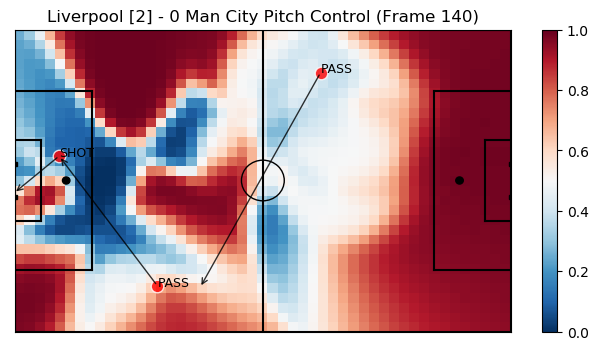

In [174]:
plot_pc_array(all_map2[-1],'Liverpool [2] - 0 Man City Pitch Control (Frame 140)', events=liv_events2)

In [92]:
liv_mcu_gain = pc_gain(all_map2)

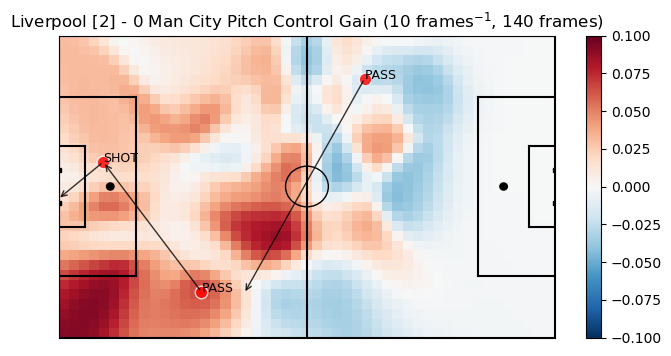

In [175]:
plot_pc_array(liv_mcu_gain,'Liverpool [2] - 0 Man City Pitch Control Gain (10 frames$^{-1}$, 140 frames)', cmin=-0.1, cmax=0.1, events=liv_events2)

In [567]:
np.array([np.sum(PPCF,axis=1)]+[np.sum(PPCF1,axis=1)])

array([[48.31888124, 47.61076686, 46.52498386, 44.93125107, 42.66130061,
        39.10980619, 34.30033976, 32.24334912, 32.34040398, 32.9968782 ,
        34.60487897, 36.2222796 , 35.42579299, 32.95869059, 31.42993785,
        31.31351985, 32.34802999, 33.18101981, 33.8013885 , 33.60080402,
        33.78281377, 36.39640889, 38.66852262, 40.42376182, 41.93525917,
        42.99494712, 43.66009458, 44.1762012 , 44.69726168, 45.23174325,
        45.66547168, 45.9187118 ],
       [41.43185864, 41.34079429, 41.25906027, 41.20062741, 41.16097085,
        41.13287829, 41.05602867, 40.81096303, 40.11207303, 38.85958978,
        38.05518961, 38.37208505, 38.2272794 , 36.71572444, 35.15179429,
        34.53335562, 33.52244761, 33.3130161 , 34.18876121, 35.07535704,
        35.64325398, 37.15054274, 39.12217285, 40.60003818, 41.608974  ,
        42.28486455, 42.79244406, 43.19159233, 43.56921515, 43.91596446,
        44.25704084, 44.60101004]])

In [555]:
# Defensive Shape + Synergy? Speed vectors/quivers # Take after their pitch control methodology

In [ ]:
# Erm some sort of MJO phase diagram thingy w fading colours to show movement btn frames as a single frame 

## Repetition for all other goals 

In [176]:
goals_list = ['Liverpool [3] - 0 Bournemouth', 'Bayern 0 - [1] Liverpool',
       'Fulham 0 - [1] Liverpool', 'Southampton 1 - [2] Liverpool',
       'Liverpool [2] - 0 Porto', 'Porto 0 - [2] Liverpool',
       'Liverpool [4] - 0 Barcelona', 'Liverpool [1] - 0 Wolves',
       'Liverpool [3] - 0 Norwich', 'Liverpool [2] - 1 Chelsea',
       'Liverpool [2] - 1 Newcastle', 'Liverpool [2] - 0 Salzburg',
       'Genk 0 - [3] Liverpool',
       'Liverpool [1] - 0 Everton', 'Liverpool [2] - 0 Everton',
       'Bournemouth 0 - 3 Liverpool', 'Liverpool [1] - 0 Watford']

#### Loop n collect all the data!

In [190]:
'Liverpool [1] - 0 Everton'.split(" ")[0]

'Liverpool'

In [194]:
for goal in goals_list:
    Path = 'F:/Last-Row/notebooks/Output/'
    liv_track, opp_track = format_data(f'{goal}')
    liv_events = format_events(f'{goal}')
    liv_events.to_pickle(Path+f'{goal}'+'_Events')
    if goal.split(' ')[0] == 'Liverpool':
        opp_track.to_pickle(Path+f'{goal}'+'_Away')
        liv_track.to_pickle(Path+f'{goal}'+'_Home')

    else:
        opp_track.to_pickle(Path+f'{goal}'+'_Home')
        liv_track.to_pickle(Path+f'{goal}'+'_Away')

### Loop n compute

In [ ]:
for goal in goals_list:
    Path = 'F:/Last-Row/notebooks/Output/'
    liv_events = pd.read_pickle(Path+f'{goal}'+'_Events')
    if goal.split(' ')[0] == 'Liverpool':
        opp_track = pd.read_pickle(Path+f'{goal}'+'_Away')
        liv_track = pd.read_pickle(Path+f'{goal}'+'_Home')

    else:
        opp_track = pd.read_pickle(Path+f'{goal}'+'_Home')
        liv_track = pd.read_pickle(Path+f'{goal}'+'_Away')
        
    fig,ax = mviz.plot_events( liv_events, color='k', indicators = ['Marker','Arrow'], annotate=True)
    fig.savefig(f'F:/Last-Row/notebooks/Output/EventFigs/{goal}.png')

In [222]:
goals_list_all = ['Liverpool [3] - 0 Bournemouth', 'Bayern 0 - [1] Liverpool',
       'Fulham 0 - [1] Liverpool', 'Southampton 1 - [2] Liverpool',
       'Liverpool [2] - 0 Porto', 'Porto 0 - [2] Liverpool',
       'Liverpool [4] - 0 Barcelona', 'Liverpool [1] - 0 Wolves',
       'Liverpool [3] - 0 Norwich', 'Liverpool [2] - 1 Chelsea',
       'Liverpool [2] - 1 Newcastle', 'Liverpool [2] - 0 Salzburg',
       'Genk 0 - [3] Liverpool', 'Liverpool [2] - 0 Man City',
       'Liverpool [1] - 0 Everton', 'Liverpool [2] - 0 Everton',
       'Bournemouth 0 - 3 Liverpool', 'Liverpool [1] - 0 Watford',
       'Leicester 0 - [3] Liverpool']

In [259]:
all_gains = []

for goal in goals_list_all[9:]:
    Path = 'F:/Last-Row/notebooks/Output/'
    liv_events = pd.read_pickle(Path+f'{goal}'+'_Events')
    if goal.split(' ')[0] == 'Liverpool':
        opp_track = pd.read_pickle(Path+f'{goal}'+'_Away')
        liv_track = pd.read_pickle(Path+f'{goal}'+'_Home')
        
        # Calculate player velocities
        tracking_home = mvel.calc_player_velocities(liv_track,smoothing=True,filter_='moving_average')
        tracking_away = mvel.calc_player_velocities(opp_track,smoothing=True,filter_='moving_average')  

    else:
        opp_track = pd.read_pickle(Path+f'{goal}'+'_Home')
        liv_track = pd.read_pickle(Path+f'{goal}'+'_Away')
        
        # Calculate player velocities
        tracking_home = mvel.calc_player_velocities(opp_track,smoothing=True,filter_='moving_average')
        tracking_away = mvel.calc_player_velocities(liv_track,smoothing=True,filter_='moving_average')  
        
    
    all_map = []
    # Get every 10th frame from frame 0 (start) to the last '10th' frame closest to the shot taken
    lastFr = int(np.floor(liv_events.iloc[-1]['Start Frame']/ 10.0))*10
    
    for i in np.arange(0,lastFr+10,10):
        if goal.split(' ')[0] == 'Liverpool':
            map_pc,x_pc,y_pc = generate_pitch_control_for_frame(i, "Liverpool", tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
        else:
             map_pc,x_pc,y_pc = generate_pitch_control_for_frame(i, "Opp", tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
        all_map.append(map_pc)
    
    liv_gain = pc_gain(all_map)
    
    all_gains.append(liv_gain)
    

FileNotFoundError: [Errno 2] No such file or directory: 'F:/Last-Row/notebooks/Output/Leicester 0 - [3] Liverpool_Events'

In [260]:
len(all_gains)

9

In [235]:
pd.read_pickle('F:/Last-Row/notebooks/Output/Fulham 0 - [1] Liverpool_Away')

,Period,Time [s],Away_15_x,Away_15_y,Away_1417_x,Away_1417_y,Away_1726_x,Away_1726_y,Away_2150_x,Away_2150_y,...,Away_9756_x,Away_9756_y,Away_13011_x,Away_13011_y,Away_13961_x,Away_13961_y,Away_13962_x,Away_13962_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
0,1,0.00,-17.282666,-30.224930,-23.488780,1.943753,-14.246370,-10.889690,-14.809404,5.634525,...,-6.288674,7.386236,-7.805459,25.558356,5.342415,7.567010,-1.598675,0.500736,0.074169,-23.743018
1,1,0.05,-17.332702,-30.177159,-23.658593,1.962840,-14.492979,-10.796053,-14.783614,5.507723,...,-6.401448,7.356454,-7.933294,25.504067,5.292342,7.566274,-1.662739,0.488954,-0.074568,-23.732083
2,1,0.10,-17.386887,-30.131945,-23.823405,1.976829,-14.738720,-10.715595,-14.769182,5.376003,...,-6.515732,7.326932,-8.062639,25.448544,5.242268,7.565538,-1.726804,0.477172,-0.231510,-23.716859
3,1,0.15,-17.445187,-30.089176,-23.983353,1.985860,-14.983617,-10.647954,-14.765903,5.239479,...,-6.631540,7.297650,-8.193471,25.391805,5.192194,7.564801,-1.790869,0.465390,-0.396505,-23.697423
4,1,0.20,-17.507571,-30.048742,-24.138574,1.990071,-15.227695,-10.592768,-14.773567,5.098264,...,-6.748888,7.268590,-8.325767,25.333870,5.142121,7.564065,-1.854934,0.453608,-0.569401,-23.673850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,1,8.90,-45.803143,-0.731123,-50.090481,1.466264,-46.099312,-2.495839,-52.433406,-6.751102,...,-39.581971,0.655418,-38.250124,9.610981,-3.570692,7.435935,-13.002209,-1.596465,-53.214286,-1.142857
179,1,8.95,-45.841647,-0.446555,-50.093247,1.463632,-46.072108,-2.438002,-52.417185,-6.668442,...,-39.649711,0.646753,-38.429111,9.514893,-3.620766,7.435199,-13.066274,-1.608247,-53.214286,-1.142857
180,1,9.00,-45.878682,-0.157607,-50.082820,1.465535,-46.051455,-2.362308,-52.405287,-6.574103,...,-39.719629,0.638042,-38.608257,9.418675,-3.670839,7.434462,-13.130339,-1.620029,-53.214286,-1.142857


In [243]:
np.array(all_gains).dump('Liverpool_PCGAIN_1st6games')

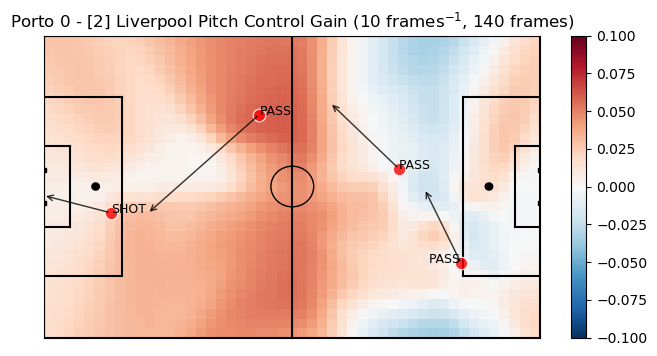

In [253]:
plot_pc_array(firstsix[-1],'Porto 0 - [2] Liverpool Pitch Control Gain (10 frames$^{-1}$, 140 frames)', cmin=-0.1, cmax=0.1, events=pd.read_pickle(Path+'Porto 0 - [2] Liverpool'+'_Events'))

In [250]:
firstsix = np.load('Liverpool_PCGAIN_1st6games',allow_pickle=True)

In [252]:
firstsix[-1]

array([[0.01839048, 0.01988411, 0.02157728, ..., 0.01435877, 0.01995693,
        0.02272284],
       [0.01771591, 0.01922431, 0.02096308, ..., 0.01692561, 0.02062317,
        0.02182388],
       [0.01699216, 0.01850595, 0.02027433, ..., 0.0176393 , 0.01968165,
        0.01961084],
       ...,
       [0.02779161, 0.02843774, 0.02855643, ..., 0.02061844, 0.02295245,
        0.02300353],
       [0.02834584, 0.02865953, 0.02844035, ..., 0.01831322, 0.02165044,
        0.02264892],
       [0.02866929, 0.0286425 , 0.02817173, ..., 0.01565587, 0.0199163 ,
        0.02188866]])

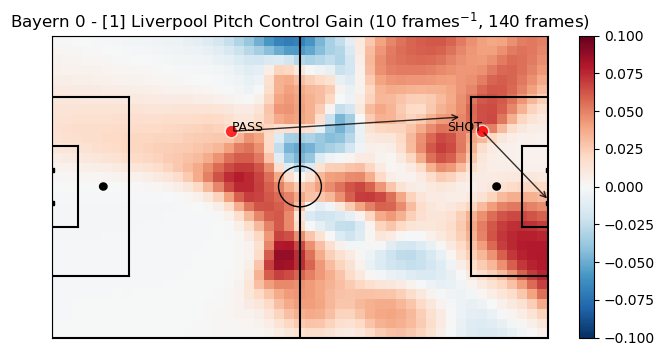

In [254]:
plot_pc_array(firstsix[1],'Bayern 0 - [1] Liverpool Pitch Control Gain (10 frames$^{-1}$, 140 frames)', cmin=-0.1, cmax=0.1, events=pd.read_pickle(Path+'Bayern 0 - [1] Liverpool'+'_Events'))

In [261]:
np.array(all_gains).dump('Liverpool_PCGAIN_9gamesfromInd9Chelsea')

In [288]:
# 2nd successful allgames

scnd_list = ['Liverpool [2] - 1 Chelsea',
       'Liverpool [2] - 1 Newcastle', 'Liverpool [2] - 0 Salzburg',
       'Genk 0 - [3] Liverpool',
       'Liverpool [1] - 0 Everton', 'Liverpool [2] - 0 Everton',
       'Bournemouth 0 - 3 Liverpool', 'Liverpool [1] - 0 Watford']

In [297]:
def check_frame(goal):
    Path = 'F:/Last-Row/notebooks/Output/'
    liv_events = pd.read_pickle(Path+f'{goal}'+'_Events')

    # Get every 10th frame from frame 0 (start) to the last '10th' frame closest to the shot taken
    lastFr = int(np.floor(liv_events.iloc[-1]['Start Frame']/ 10.0))*10
    return lastFr

In [298]:
frames = []
for gm in scnd_list:
    frames.append(int(check_frame(gm)))

In [299]:
frames

[160, 120, 160, 150, 140, 160, 240, 120, 190]

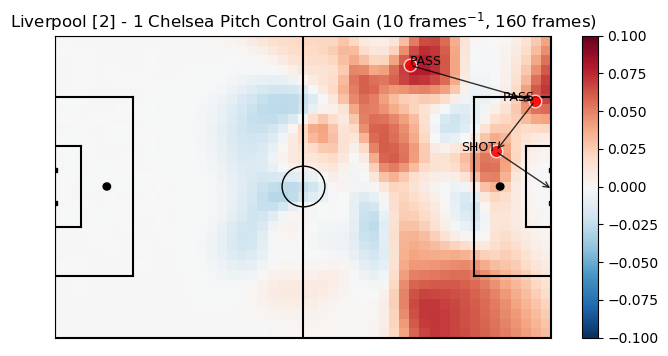

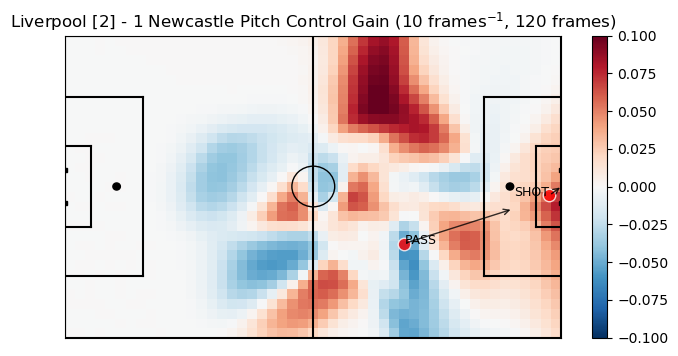

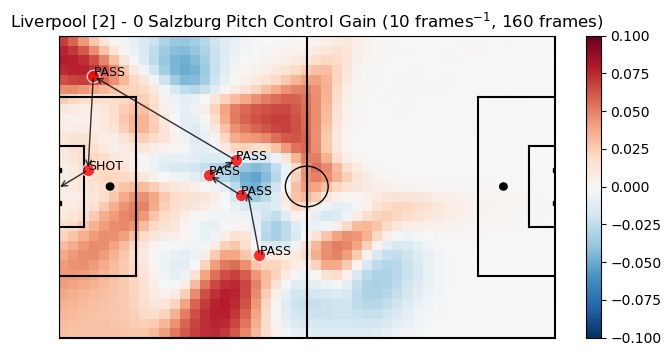

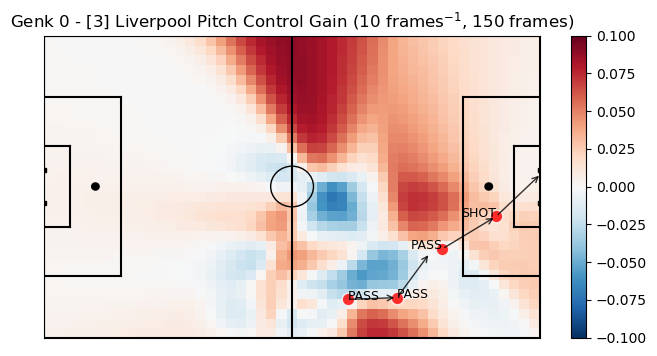

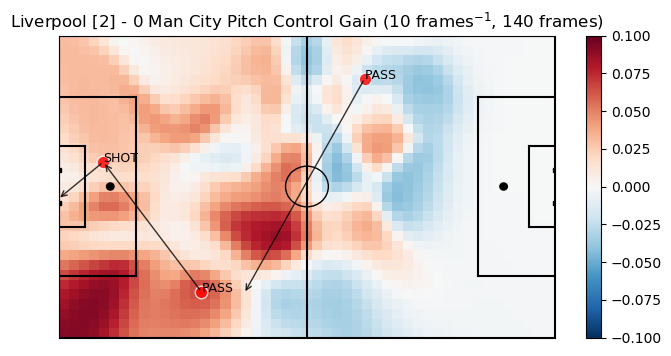

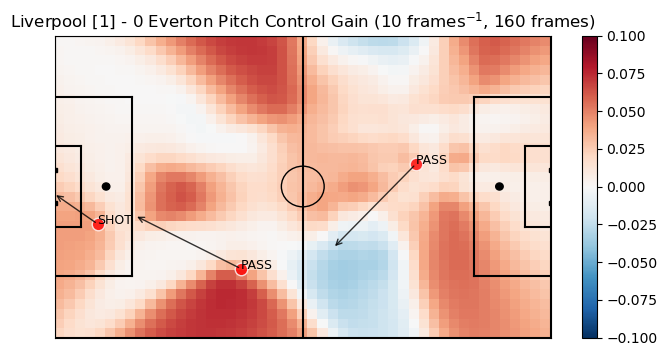

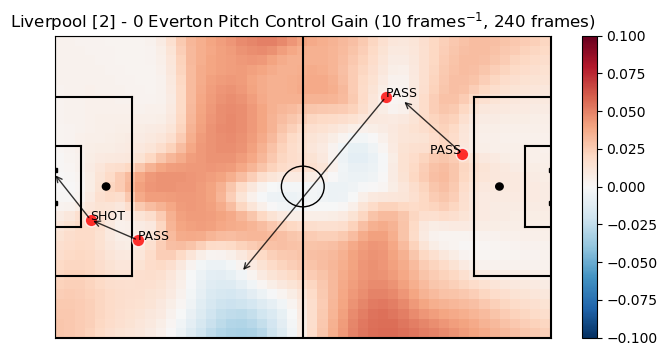

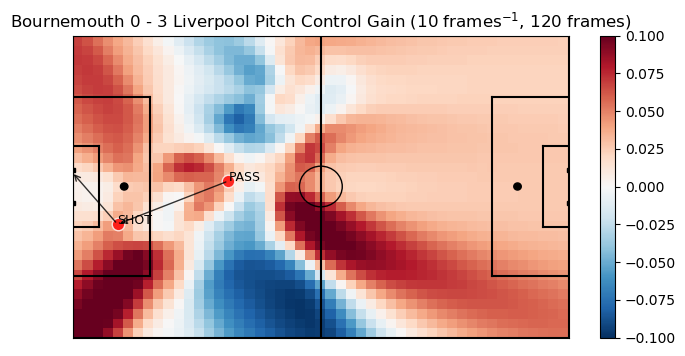

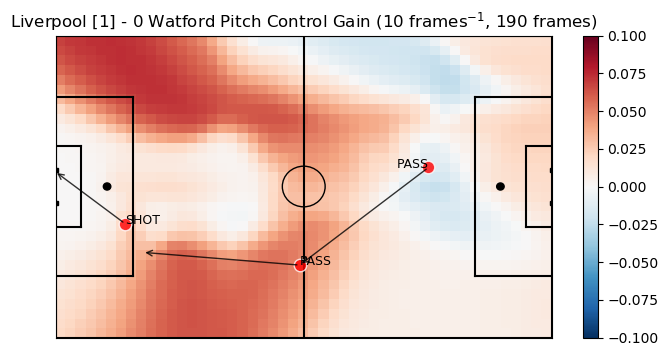

In [302]:
for gm in range(len(scnd_list)):
    

    fig = plot_pc_array(all_gains[gm],f'{scnd_list[gm]}'+' Pitch Control Gain (10 frames$^{-1}$, '+str(frames[gm])+' frames)', cmin=-0.1, cmax=0.1, events=pd.read_pickle(Path+f'{scnd_list[gm]}'+'_Events'))
    fig.savefig(f'{scnd_list[gm]}'+'.png')

In [303]:
first_list=['Liverpool [3] - 0 Bournemouth', 'Bayern 0 - [1] Liverpool',
       'Fulham 0 - [1] Liverpool', 'Southampton 1 - [2] Liverpool',
       'Liverpool [2] - 0 Porto', 'Porto 0 - [2] Liverpool']

In [306]:
frames1 = []
for gm in first_list:
    frames1.append(int(check_frame(gm)))

IndexError: index 6 is out of bounds for axis 0 with size 6

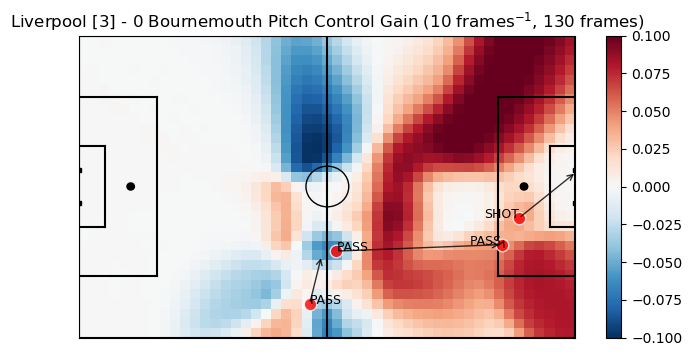

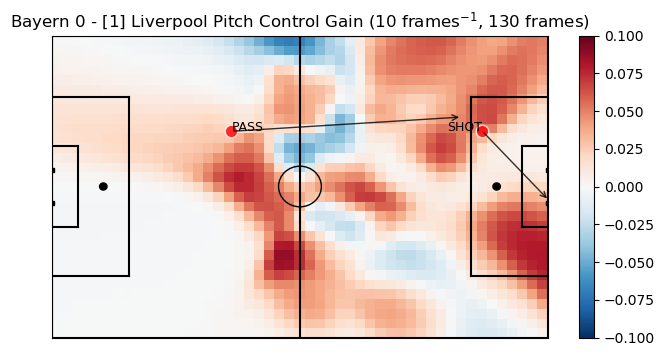

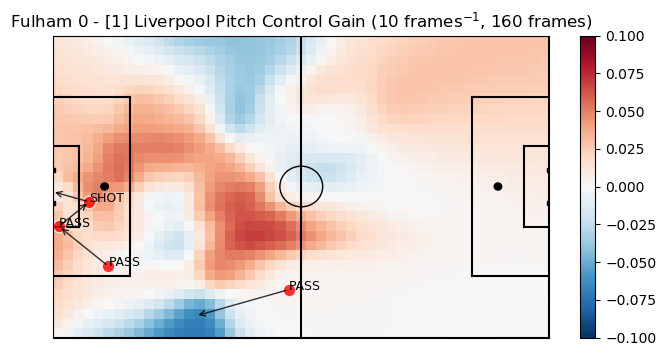

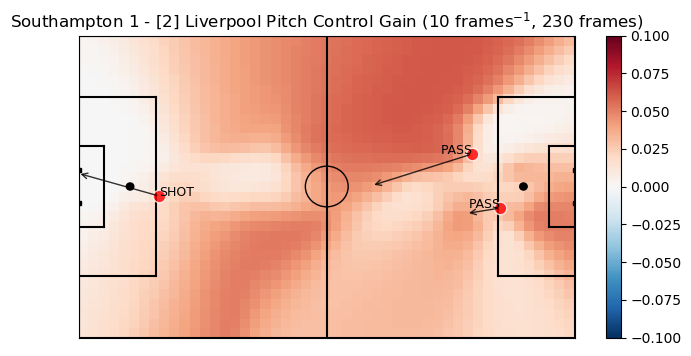

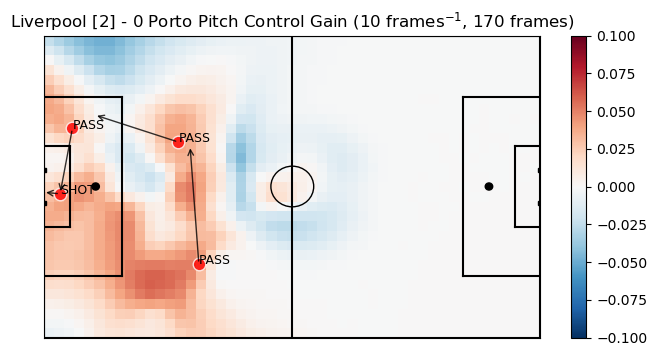

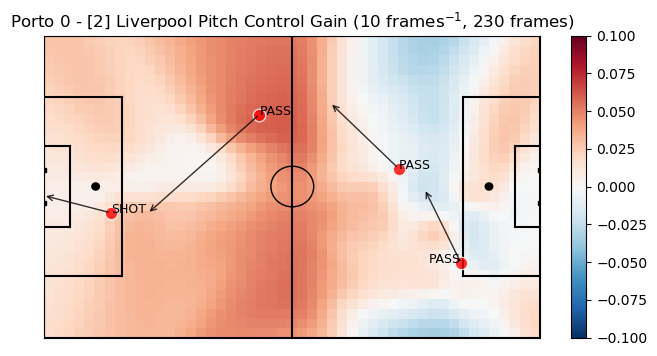

In [307]:
for gm in range(len(first_list)):
    

    fig = plot_pc_array(firstsix[gm],f'{first_list[gm]}'+' Pitch Control Gain (10 frames$^{-1}$, '+str(frames1[gm])+' frames)', cmin=-0.1, cmax=0.1, events=pd.read_pickle(Path+f'{first_list[gm]}'+'_Events'))
    fig.savefig(f'{first_list[gm]}'+'.png')